## OCNT-DMSLIB-0-UAS DMS Assay Run #1: MC4R, Gq (DMS8)

| ID | Condition | Concentration | Replicates
| --- | ----------- | --- | ----------- |
| 1 | None | 0 | 4 |
| 2 | aMSH | 2e-8 | 4 |
| 3 | aMSH | 5e-8 | 4 |
| 4 | aMSH | 1e-6 | 4 |
| 5 | THIQ | 3e-9 | 4 |
| 6 | THIQ | 9e-9 | 4 |
| 7 | THIQ | 1e-7 | 3 |

This report generates summary statistics and plots for MC4R, Gq (DMS8) identically to that of TYK2. Some sections that are TYK2-specific (e.g. drug resistence GoF, spike-ins) are omitted, and the ClinVar comparison is added (since, for MC4R, that association is much stronger than for TYK2).

1. [Barcode Sequencing Distributions](#part1)
2. [Inference and Stop Codon Effects](#part2)
3. [Visualizations](#part3)
4. [ClinVar](#part4)
5. [Unnormalized Summary Statistics](#part5)
6. [Comparing aMSH to THIQ](#part6)

### Barcode Sequencing Distributions <a name="part1"></a>

To start, we plot the distribution of unique barcodes per variant across samples:

In [2]:
library(magrittr)
library(data.table)
library(ggpubr)
library(ggsci)
library(vroom)
library(scales)
library(scico)
library(ggridges)
library(knitr)
library(fs)
library(patchwork)
library(ggnewscale)
library(tidyverse)

scale_fill_scico_mid <- function(..., mid = 0, alpha = NULL, begin = 0, end = 1, direction = 1, reverse = TRUE ,palette = "broc") {
  if (!requireNamespace("ggplot2", quietly = TRUE)) {
        stop("ggplot2 is required for this functionality", call. = FALSE)
  }
  force(mid)
  ggplot2::continuous_scale(
    aesthetics = "fill", 
    scale_name = "gradient2",
    palette = scales::gradient_n_pal(
      colours = scico(256, alpha, begin, end, direction, palette), 
      values = NULL, space = "Lab"),
    guide="colourbar",
    rescaler = function(x, to = c(0, 1), from = range(x, na.rm = TRUE)) {
      scales::rescale_mid(x, to, from, mid)
    },
    ...
  )
}

In [3]:
mapped_counts <- vroom("../pipeline/OCNT-DMSLIB-0-UAS-DMS8/mc4r-uas-form.mapped-counts.tsv",
                          col_names = c("sample", "barcode", "count", "lib", "chunk", "wt_aa", "pos",
                                        "mut_aa", "wt_codon", "mut_codon", "chunkID",
                                        "dox", "condition", "condition_conc","clone")) %>%
    group_by(sample) %>%
    mutate(mut_aa = if_else(mut_aa %in% c("*", "X"), "*", mut_aa),
           condition = as.factor(paste0(condition, condition_conc)),
           stop_counts = sum(count[which(mut_aa == "*")]),
           mut_aa = if_else(wt_aa == mut_aa | is.na(mut_aa), "WT", mut_aa),
           mut_aa = relevel(as.factor(mut_aa), ref = "WT"))

Rows: 7309805 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (9): sample, barcode, lib, wt_aa, mut_aa, wt_codon, mut_codon, chunkID, ...
dbl (5): count, chunk, pos, dox, condition_conc
lgl (1): clone

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
bc_counts_aa <- mapped_counts %>%
    filter(mut_aa != "WT") %>%
    group_by(sample,wt_aa,mut_aa,pos) %>%
    count()

bc_counts_codon <- mapped_counts %>%
    filter(mut_aa != "WT") %>%
    group_by(sample,wt_codon,mut_codon,pos) %>%
    count()

res_count <- bc_counts_aa %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = n)) +
        theme_pubr() +
        geom_hline(yintercept = 30, color = "red") +
        ylab("number of unique barcodes") + ggtitle("AA-level unique barcode counts")

codon_count <- bc_counts_codon %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = n)) +
        theme_pubr() +
        geom_hline(yintercept = 30, color = "red")  +
        ylab("number of unique barcodes") + ggtitle("Codon-level unique barcode counts")

res_count_log <- bc_counts_aa %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = log10(n))) +
        theme_pubr() +
        geom_hline(yintercept = log10(30), color = "red") +
        ylab("number of unique barcodes") + ggtitle("AA-level unique barcode counts, log10")

codon_count_log <- bc_counts_codon %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = log10(n))) +
        theme_pubr() +
        geom_hline(yintercept = log10(30), color = "red")  +
        ylab("number of unique barcodes") + ggtitle("Codon-level unique barcode counts, log10")

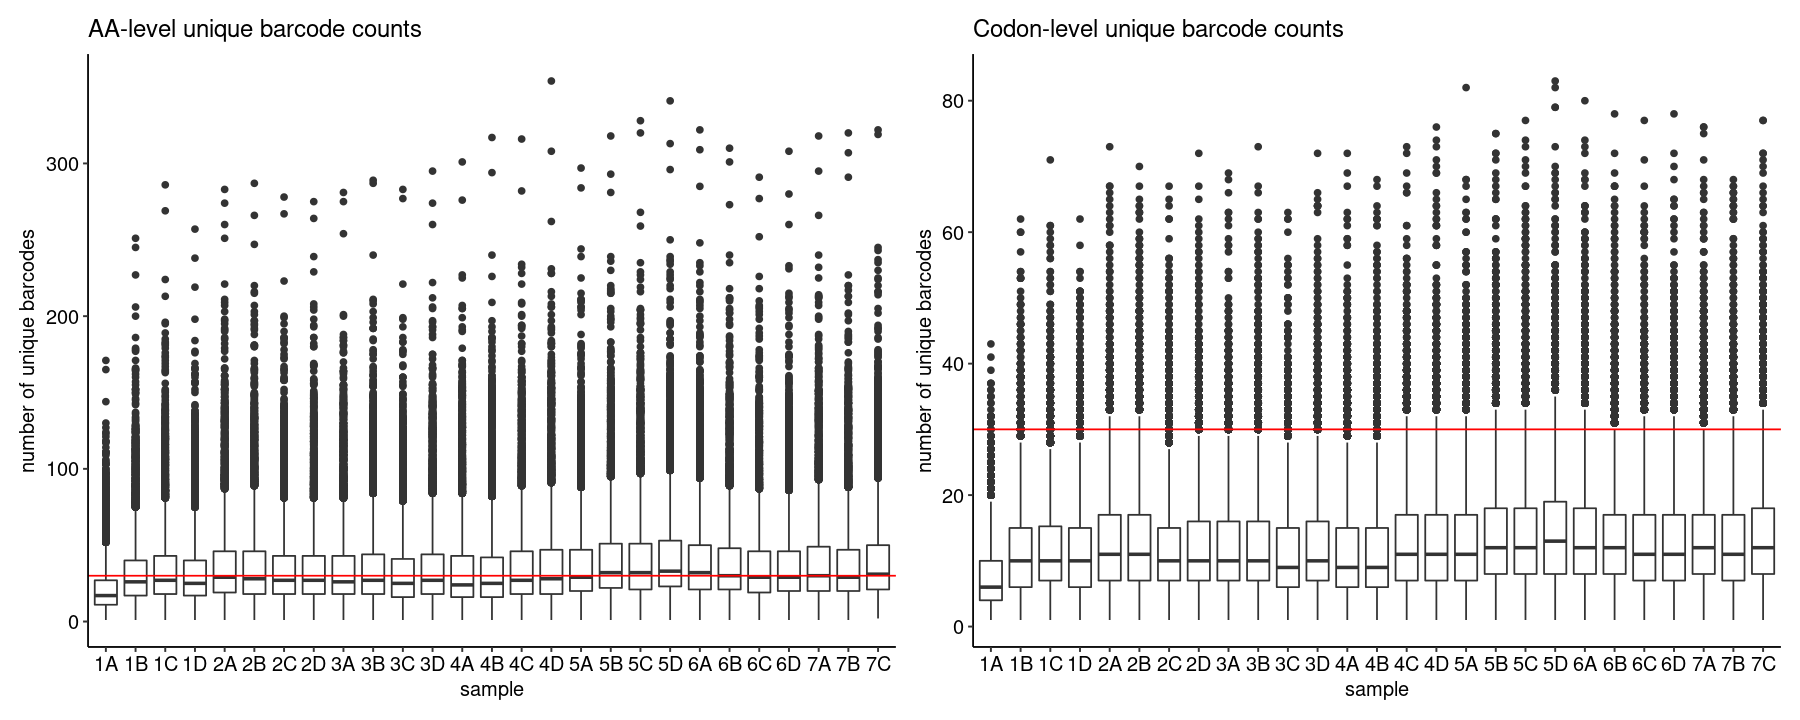

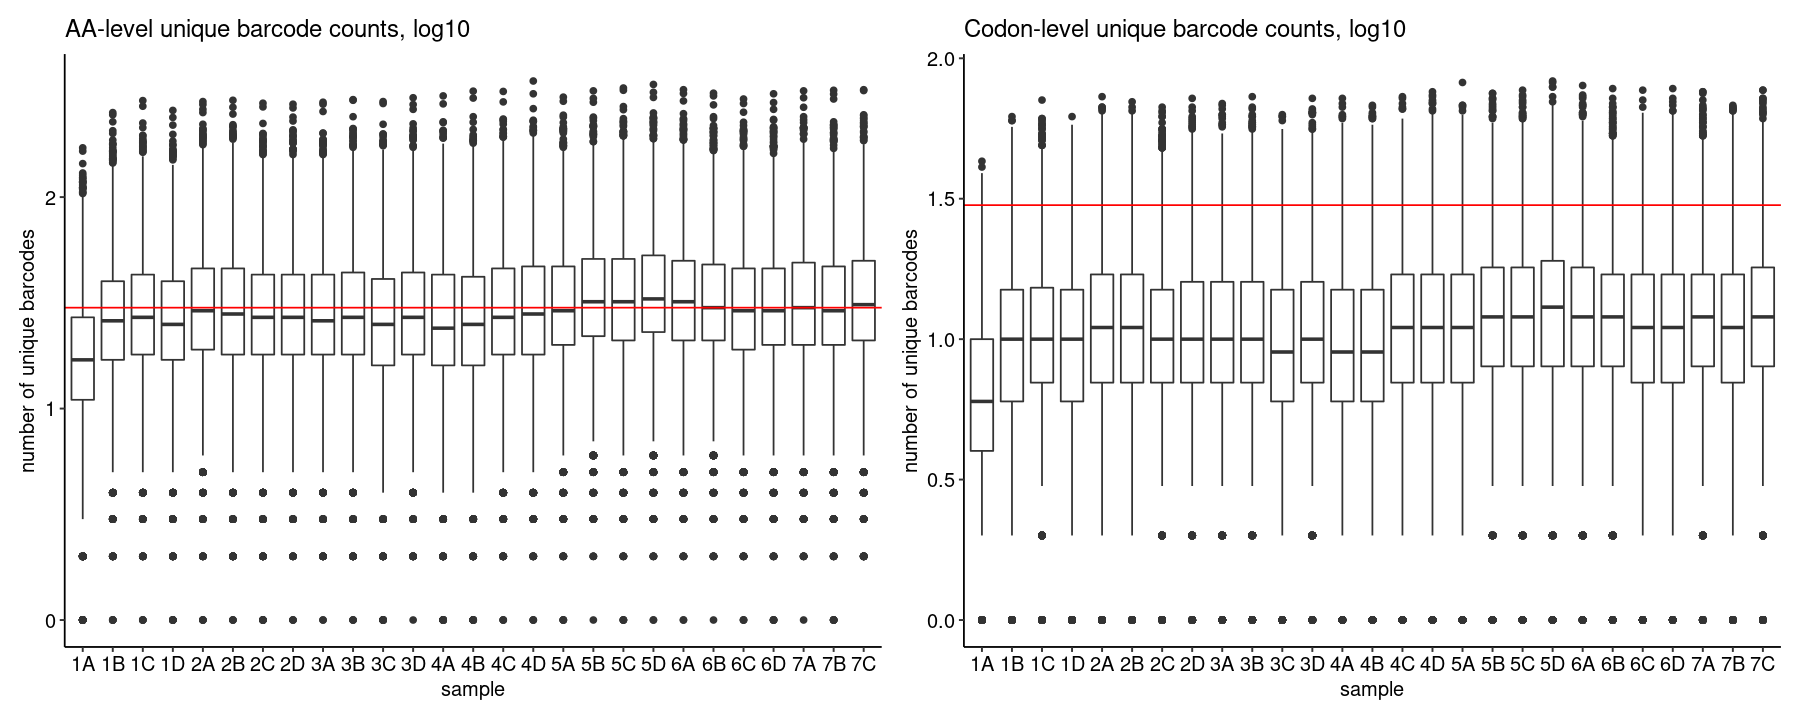

In [5]:
options(repr.plot.width = 15, repr.plot.height = 6)
res_count + codon_count
res_count_log + codon_count_log 

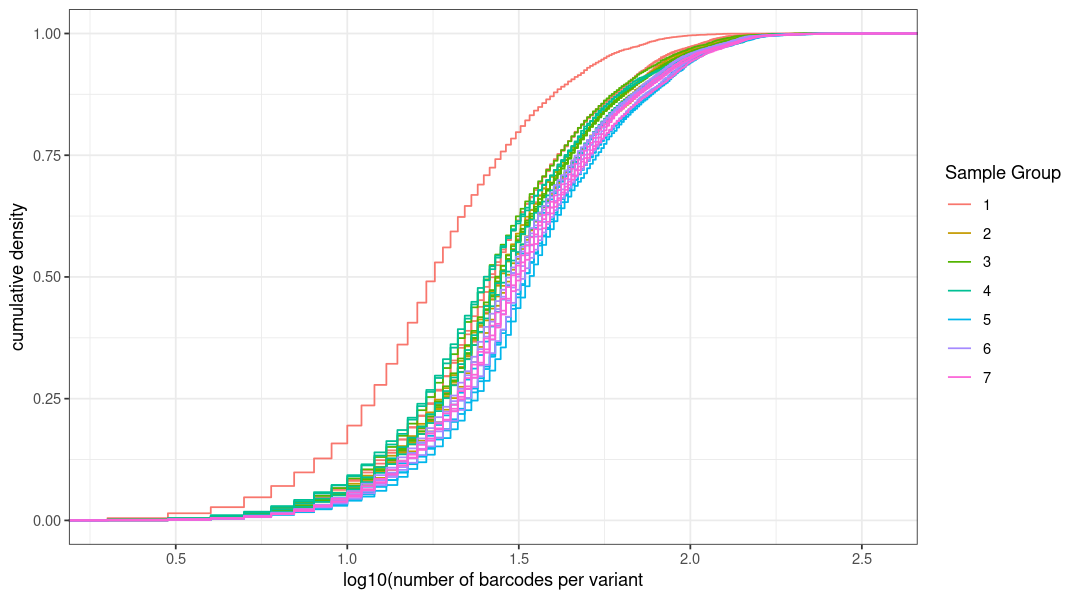

In [6]:
options(repr.plot.width = 9, repr.plot.height = 5)
bc_counts_aa %>%
    mutate(`Sample Group` = str_sub(sample, 1, 1)) %>%
    ggplot() +
        stat_ecdf(aes(x = log10(n+1), group = sample, color = `Sample Group`)) +
        theme_bw() +
        xlab("log10(number of barcodes per variant") +
        ylab("cumulative density") 

In [7]:
plot_coverage <- function(bcs, sample_id) {
    
    wt_aa <- read_tsv("../data/mc4r/mc4r-wt-prot.tsv") %>%
        select(WT_AA_Short, Pos) %>%
        rename("pos" = "Pos", "wt_aa" = "WT_AA_Short")
    
    bcs_subset <- bcs %>%
        filter(sample == sample_id)
    
    allpos <- expand_grid("pos" = unique(bcs$pos),
                     "mut_aa" = unique(bcs$mut_aa)) %>%
        filter(!paste0(pos, mut_aa) %in% paste0(wt_aa$pos, wt_aa$wt_aa))

    bcs_subset_expanded <- allpos %>%
        left_join(bcs_subset) %>%
        mutate(n = ifelse(is.na(n), 0, n))
    
    the_plot <- ggplot(bcs_subset_expanded) +
        geom_line(aes(x = as.numeric(pos), y = log10(n))) +
        theme_bw(base_size = 16) +
        ggtitle(paste0("Sample ", sample_id)) +
        facet_wrap(~mut_aa, ncol = 1) +
        xlab("MC4R position") + ylab("log10(number of unique barcodes)")
    
    ggsave(paste0("coverage-plots/OCNT-DMSLIB-0-CRE-assay-run1-sample", sample_id, ".pdf"),
           the_plot, width = 10, height = 20)
    
    return(the_plot)
}

coverage_plots <- map(.x = unique(bc_counts_aa$sample), .f = ~plot_coverage(bc_counts_aa, .))

Rows: 332 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): WT_AA_Short, WT_AA
dbl (1): Pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining, by = c("pos", "mut_aa")
Rows: 332 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): WT_AA_Short, WT_AA
dbl (1): Pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining, by = c("pos", "mut_aa")
Rows: 332 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): WT_AA_Short, WT_AA
dbl (1): Pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this m

We can stratify this by residue, but at the expense of generating very large plots. All full coverage plots are stored [here](./coverage-plots) for all samples, and a representative sample (1A) is shown below:

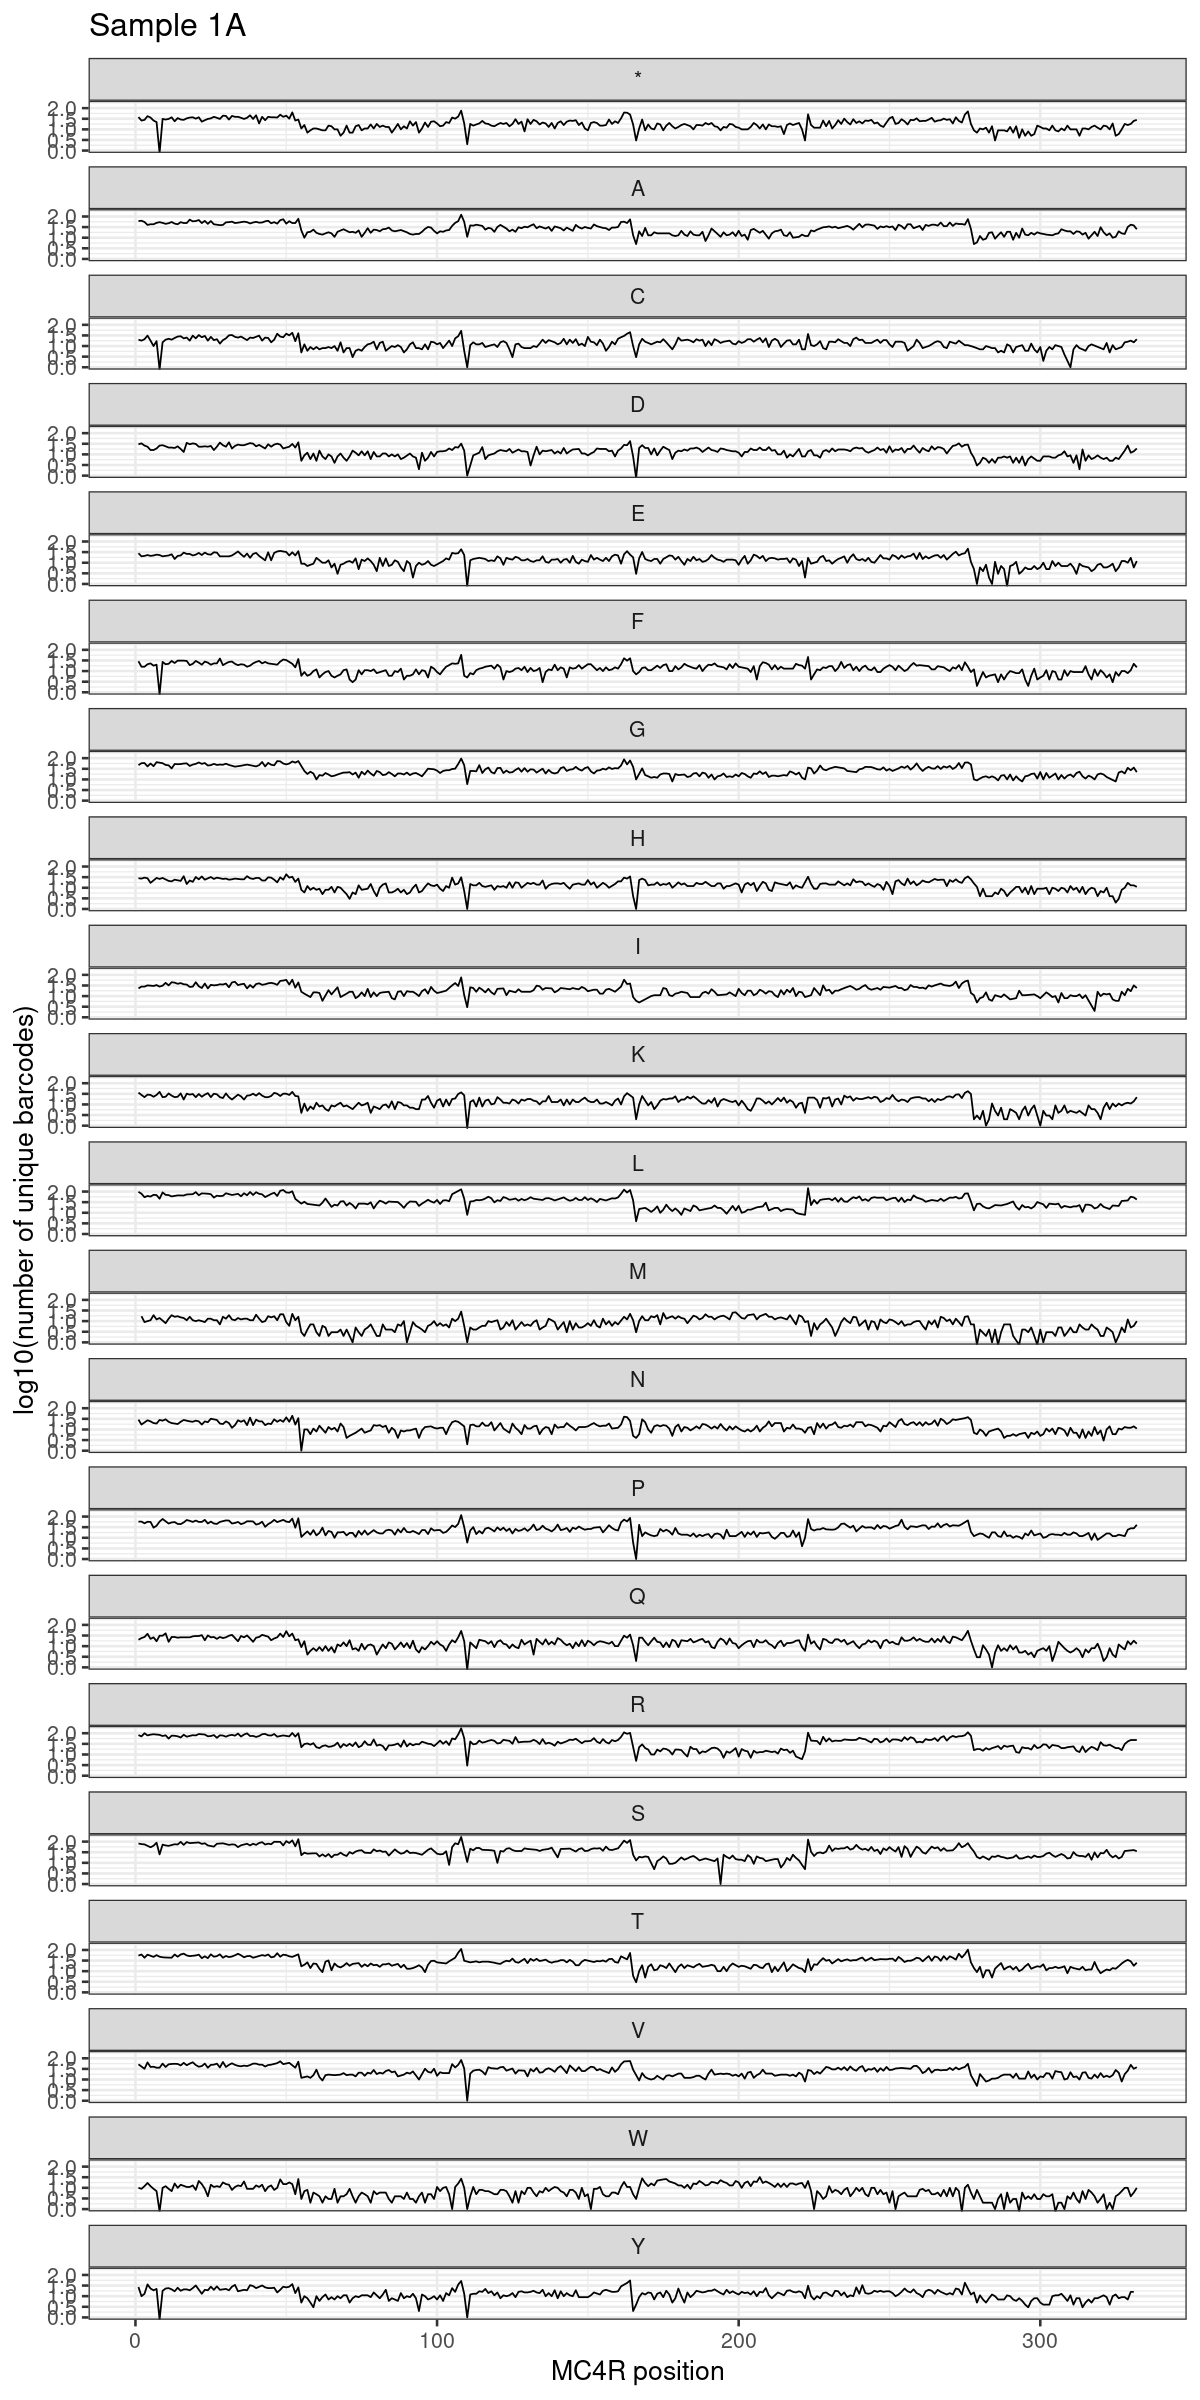

In [8]:
options(repr.plot.width = 10, repr.plot.height = 20)
coverage_plots[[1]]

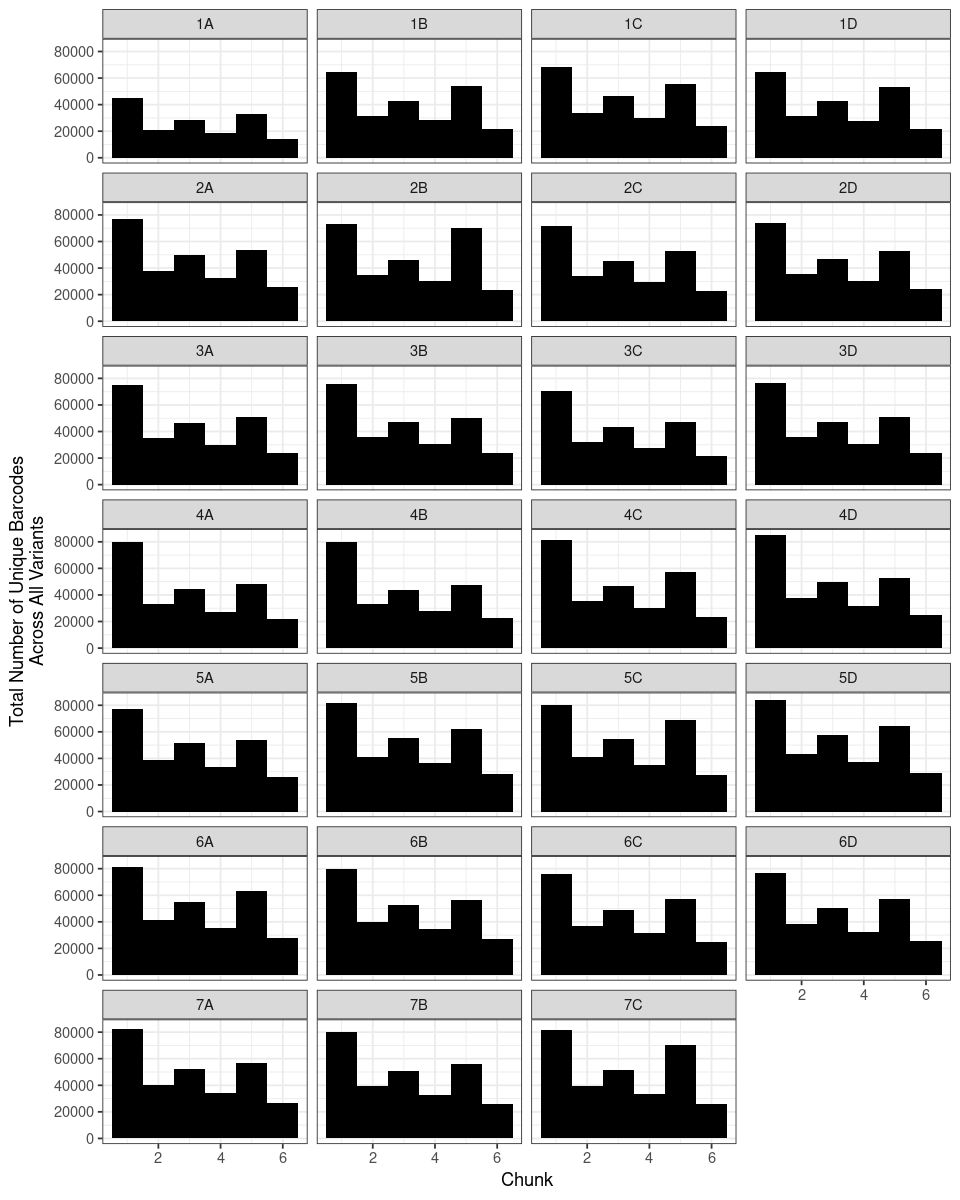

In [9]:
options(repr.plot.width = 8, repr.plot.height = 10)
mapped_counts %>%
    ungroup() %>%
    count(sample, chunk) %>%
    mutate(chunk = as.numeric(chunk)) %>%
    ggplot() +
        geom_bar(aes(x = chunk, y = n), width = 1, color = NA, fill = "black", stat = "identity") +
        theme_bw() +
        facet_wrap(~sample, ncol = 4) +
        xlab("Chunk") + ylab("Total Number of Unique Barcodes\nAcross All Variants")

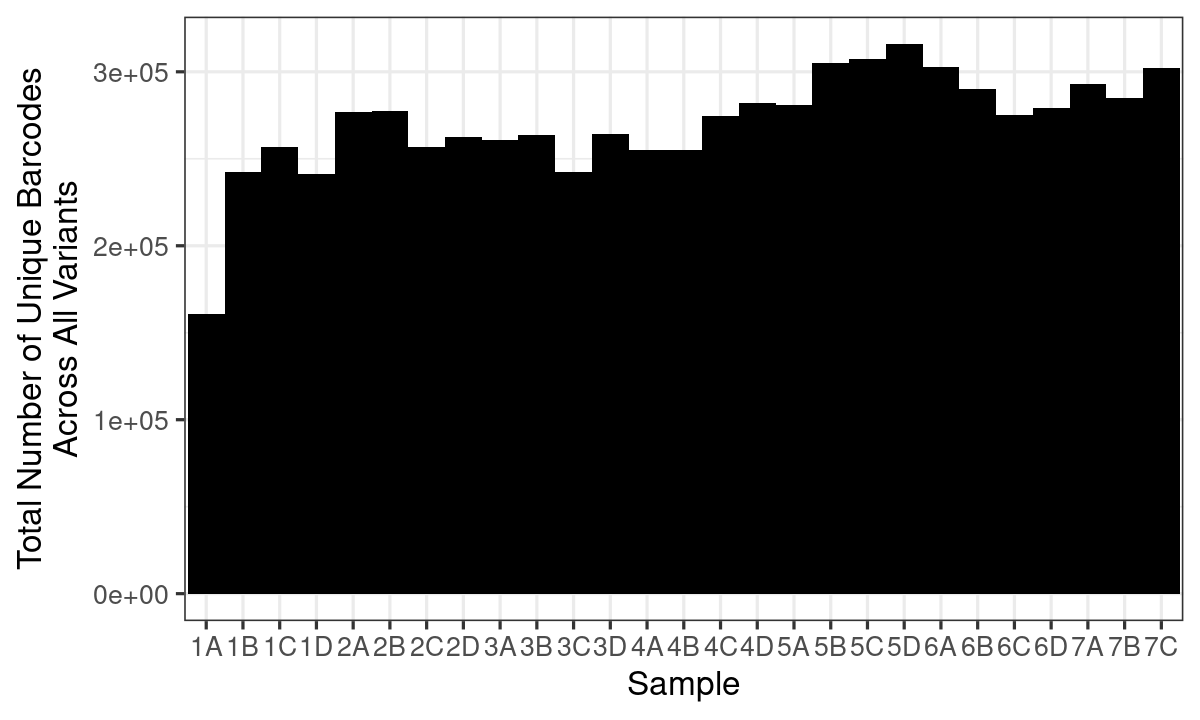

In [10]:
options(repr.plot.width = 10, repr.plot.height = 6)
mapped_counts %>%
    ungroup() %>%
    count(sample) %>%
    ggplot() +
        geom_bar(aes(x = sample, y = n), width = 1, color = NA, fill = "black", stat = "identity") +
        theme_bw(base_size = 20) +
        xlab("Sample") + ylab("Total Number of Unique Barcodes\nAcross All Variants")

### Inference and Stop Codon Effects <a name="part2"></a>

Next, we can compute the normalizing contrasts against Forskolin or None, and plot the results. First, we can quickly check if there are any positions missing, and see that there are two partial positional dropouts at position 8 and 293 (meaning total coverage is still approx. 99.89%):

In [3]:
sumstats <- dir_ls(path = "../sumstats/MC4R/DMS8/", regexp = "mc4r-uas.*combined.sumstats.tsv") %>%
    map_dfr(read_tsv, col_types = c("ncccnnnnnc")) %>%
    filter(grepl("aa",term)) %>%
    separate(term, c("condition", "aa"), ":") %>%
    mutate(estimate = estimate / log(2),
           std.error = std.error / log(2),
           condition = gsub("condition", "", condition),
           group = if_else(aa %in% c("mut_aa*", "mut_aaX"), chunk, "Non-Stop"),
           aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*","X"), "*", aa))

wt_aa <- read_tsv("../data/mc4r/mc4r-wt-prot.tsv") %>%
    select(WT_AA_Short, Pos) %>%
    rename("pos" = "Pos", "wt_aa" = "WT_AA_Short")

Rows: 332 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): WT_AA_Short, WT_AA
dbl (1): Pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
aa_uniq <- unique(sumstats$aa)
pos_uniq <- 1:332

expand_grid("aa" = aa_uniq, "pos" = pos_uniq) %>%
    left_join(sumstats, by = c("aa", "pos")) %>%
    filter(is.na(estimate), !paste0(pos,aa) %in% paste0(wt_aa$pos, wt_aa$wt_aa)) %>%
    select(aa, pos) %>%
    arrange(pos) %>%
    rename("missing at position" = "pos") %>%
    kable("markdown")



|aa | missing at position|
|:--|-------------------:|
|C  |                   8|
|F  |                   8|
|W  |                   8|
|*  |                   8|
|Y  |                   8|
|M  |                 293|
|W  |                 293|

Now, we compute the normalizing contrasts and evaluate stop codon effects across each chunk:

In [7]:
compute_difference <- function(test, control, sumstats) {
    
    df1 <- sumstats %>% filter(condition == test) %>% select(-condition)
    df2 <- sumstats %>% filter(condition == control) %>% select(-condition)
    
    df <- inner_join(df1, df2,
                     by = c("pos", "clone", "chunk", "aa", "version", "dispersion"))
    
    new_stats <- df %>%
        mutate(estimate = estimate.x - estimate.y,
               std.error = sqrt(std.error.x^2 + std.error.y^2)) %>%
        select(pos, clone, chunk, aa, estimate, std.error, dispersion, version) %>%
        ungroup()
    
    new_stats$condition = paste0(test, " - ", control)
    
    return(new_stats)
    
}

conditions <- unique(sumstats$condition)
noneIdx <- which(conditions == "None0")

sumstats_none_contr <- map_dfr(conditions[-noneIdx],
                         ~compute_difference(test = .,
                                            control = "None0",
                                            sumstats = sumstats)) %>%
    mutate(condition = factor(condition,
                              levels = c("aMSH2e-08 - None0",
                                         "aMSH5e-08 - None0",
                                         "aMSH1e-06 - None0",
                                         "aMSH5e-10 - None0",
                                         "THIQ3e-09 - None0",
                                         "THIQ9e-09 - None0",
                                         "THIQ1e-07 - None0")))



sumstats_all <- sumstats_none_contr %>%
    mutate(statistic = estimate / std.error,
           p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                                 (1-pnorm(statistic, sd = 1))*2),
           p.adj = p.adjust(p.value, method = "BH"))

In [5]:
write_tsv(sumstats_all, "../sumstats/MC4R/MC4R-DMS8-Gq.tsv")

Finally, we can count up all significant effects at a 1% FDR in all comparisons. This verifies what is visually clear above, namely the relatively high basal activity (meaning significant variant effects in the absence of agonist): 

In [43]:
sumstats_all %>%
    count(condition, sig = if_else(p.adj < 0.01, "Significant (FDR < 0.01)", "Non-Significant")) %>%
    pivot_wider(names_from = sig, values_from = n) %>%
    kable(type = "markdown")



|condition         | Non-Significant| Significant (FDR < 0.01)|
|:-----------------|---------------:|------------------------:|
|aMSH2e-08 - None0 |            6572|                       61|
|aMSH5e-08 - None0 |            6423|                      210|
|aMSH1e-06 - None0 |            5833|                      800|
|THIQ3e-09 - None0 |            6613|                       20|
|THIQ9e-09 - None0 |            6593|                       40|
|THIQ1e-07 - None0 |            6539|                       94|

### Visualizations <a name="part3"></a>

Next, we generate the standard visualizations for these data, namely heatmaps (using log2FoldChange or Z-statistic) and volcano plots:

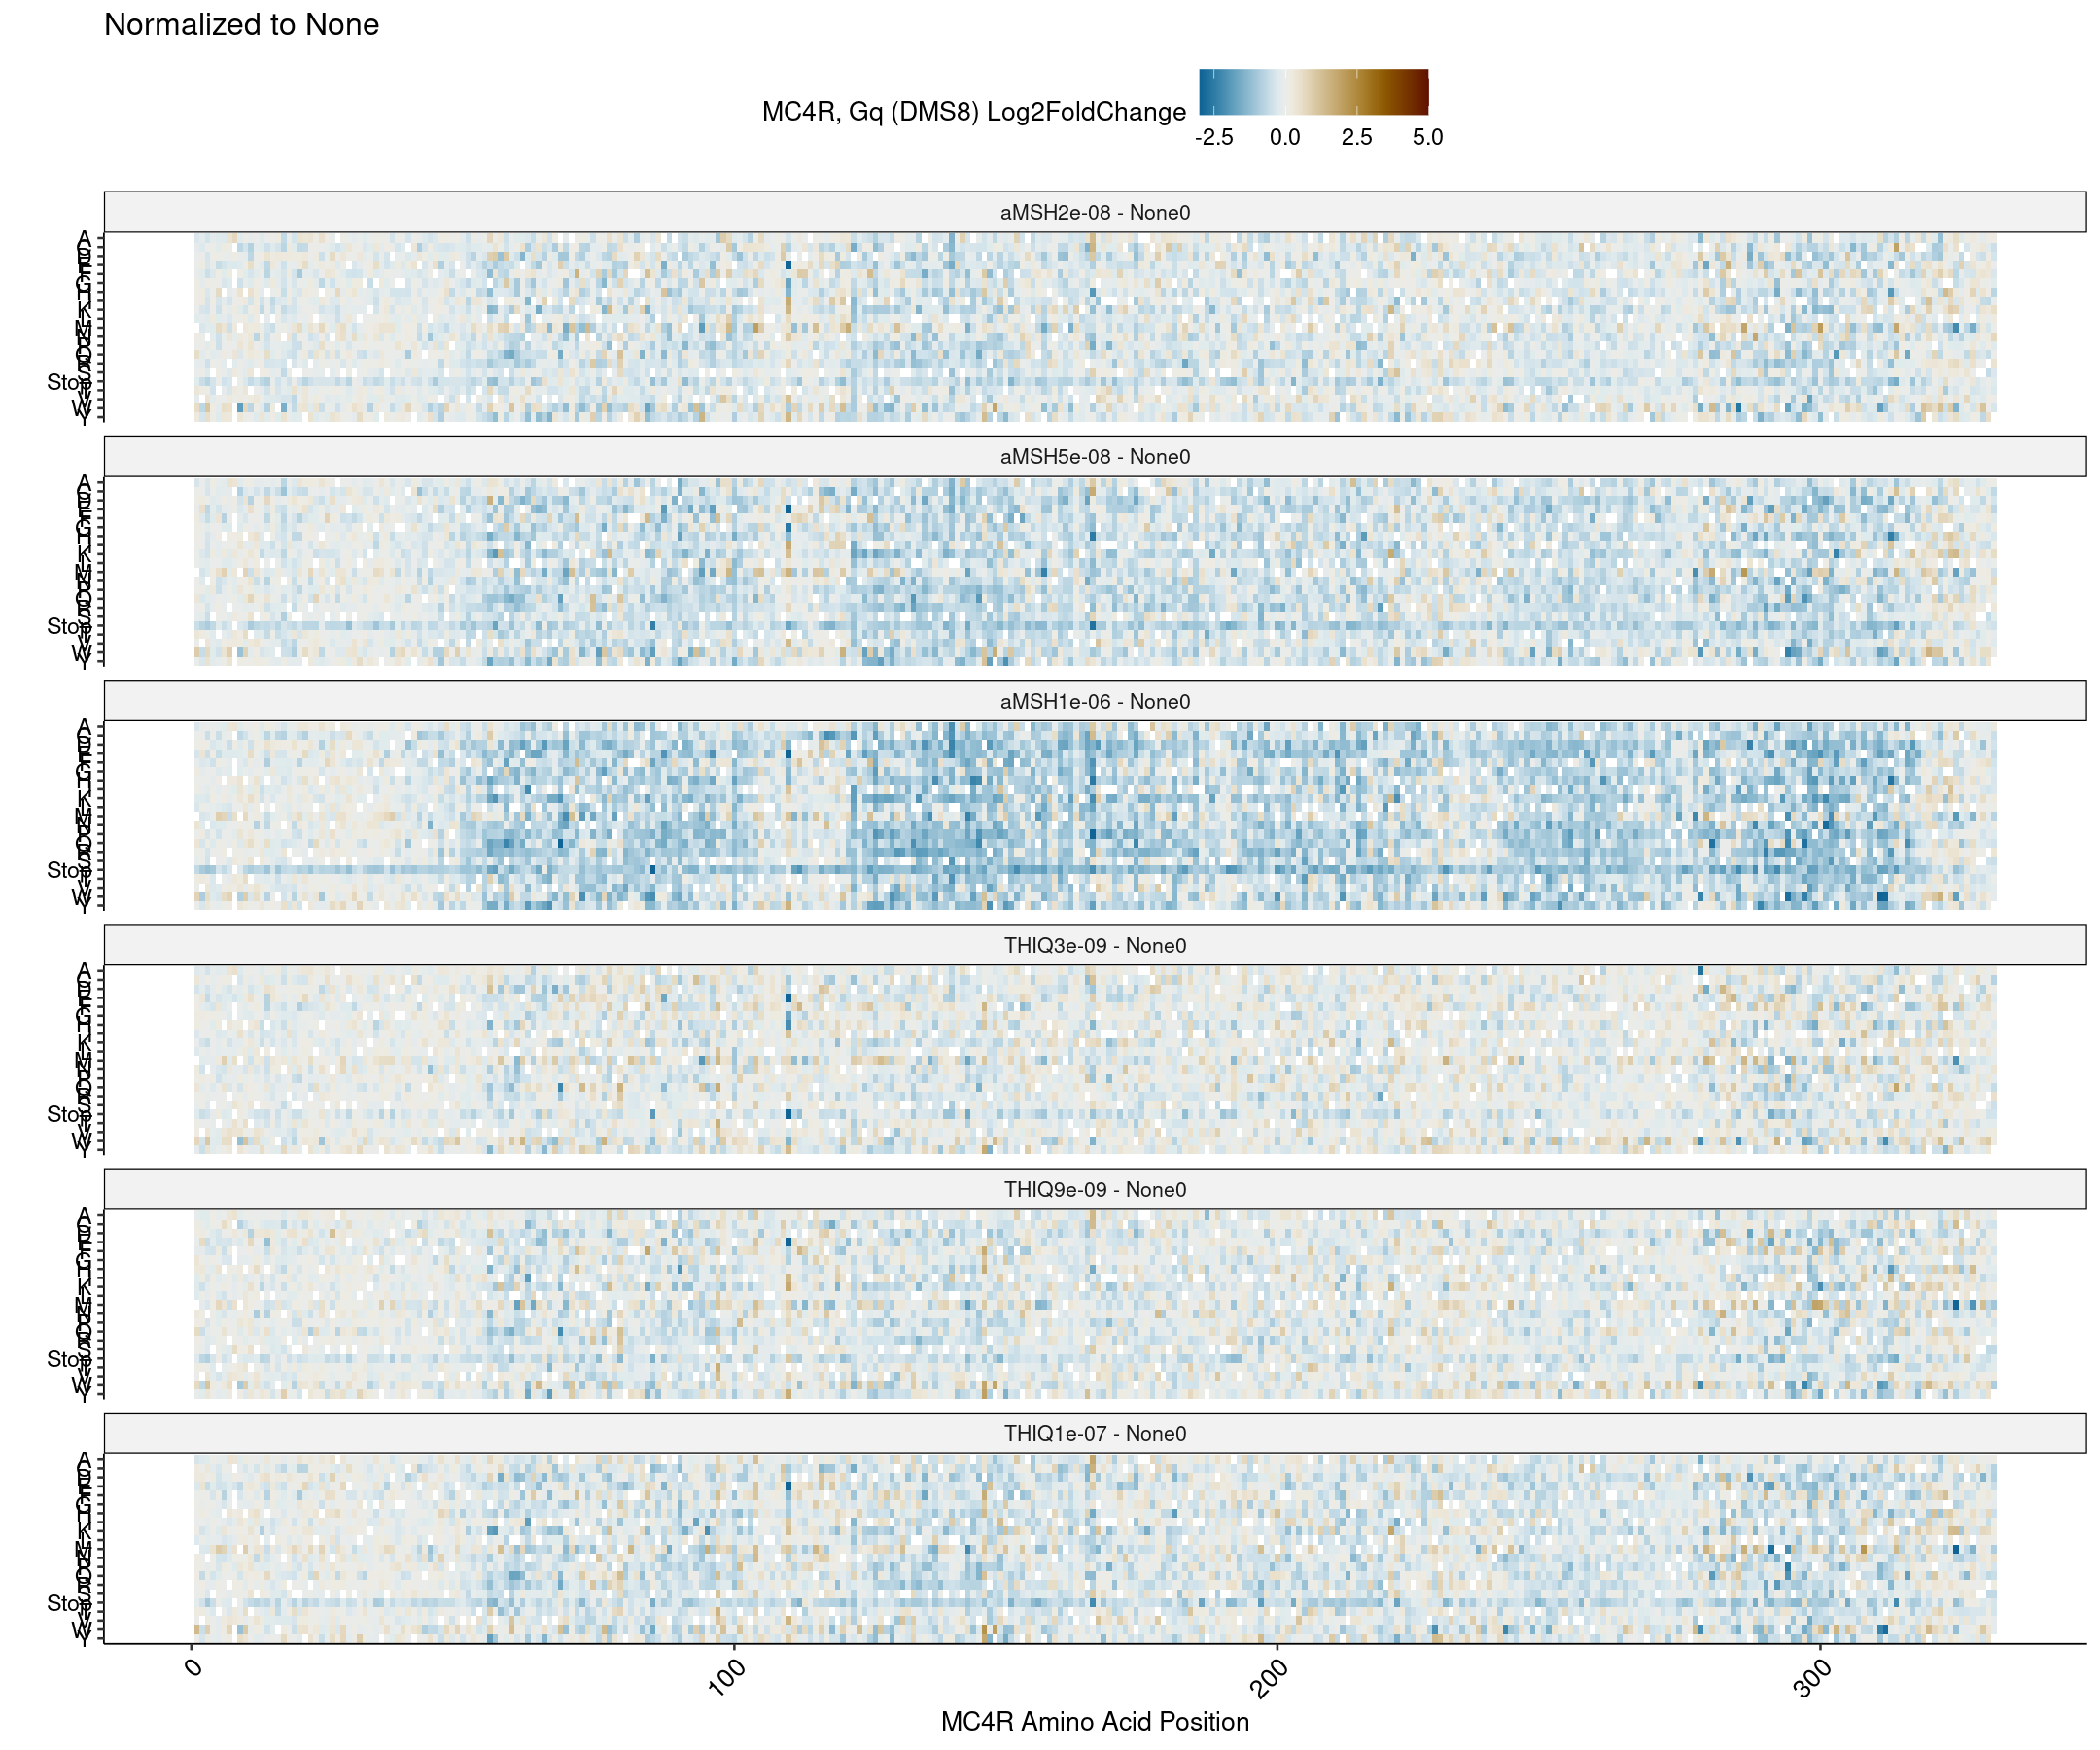

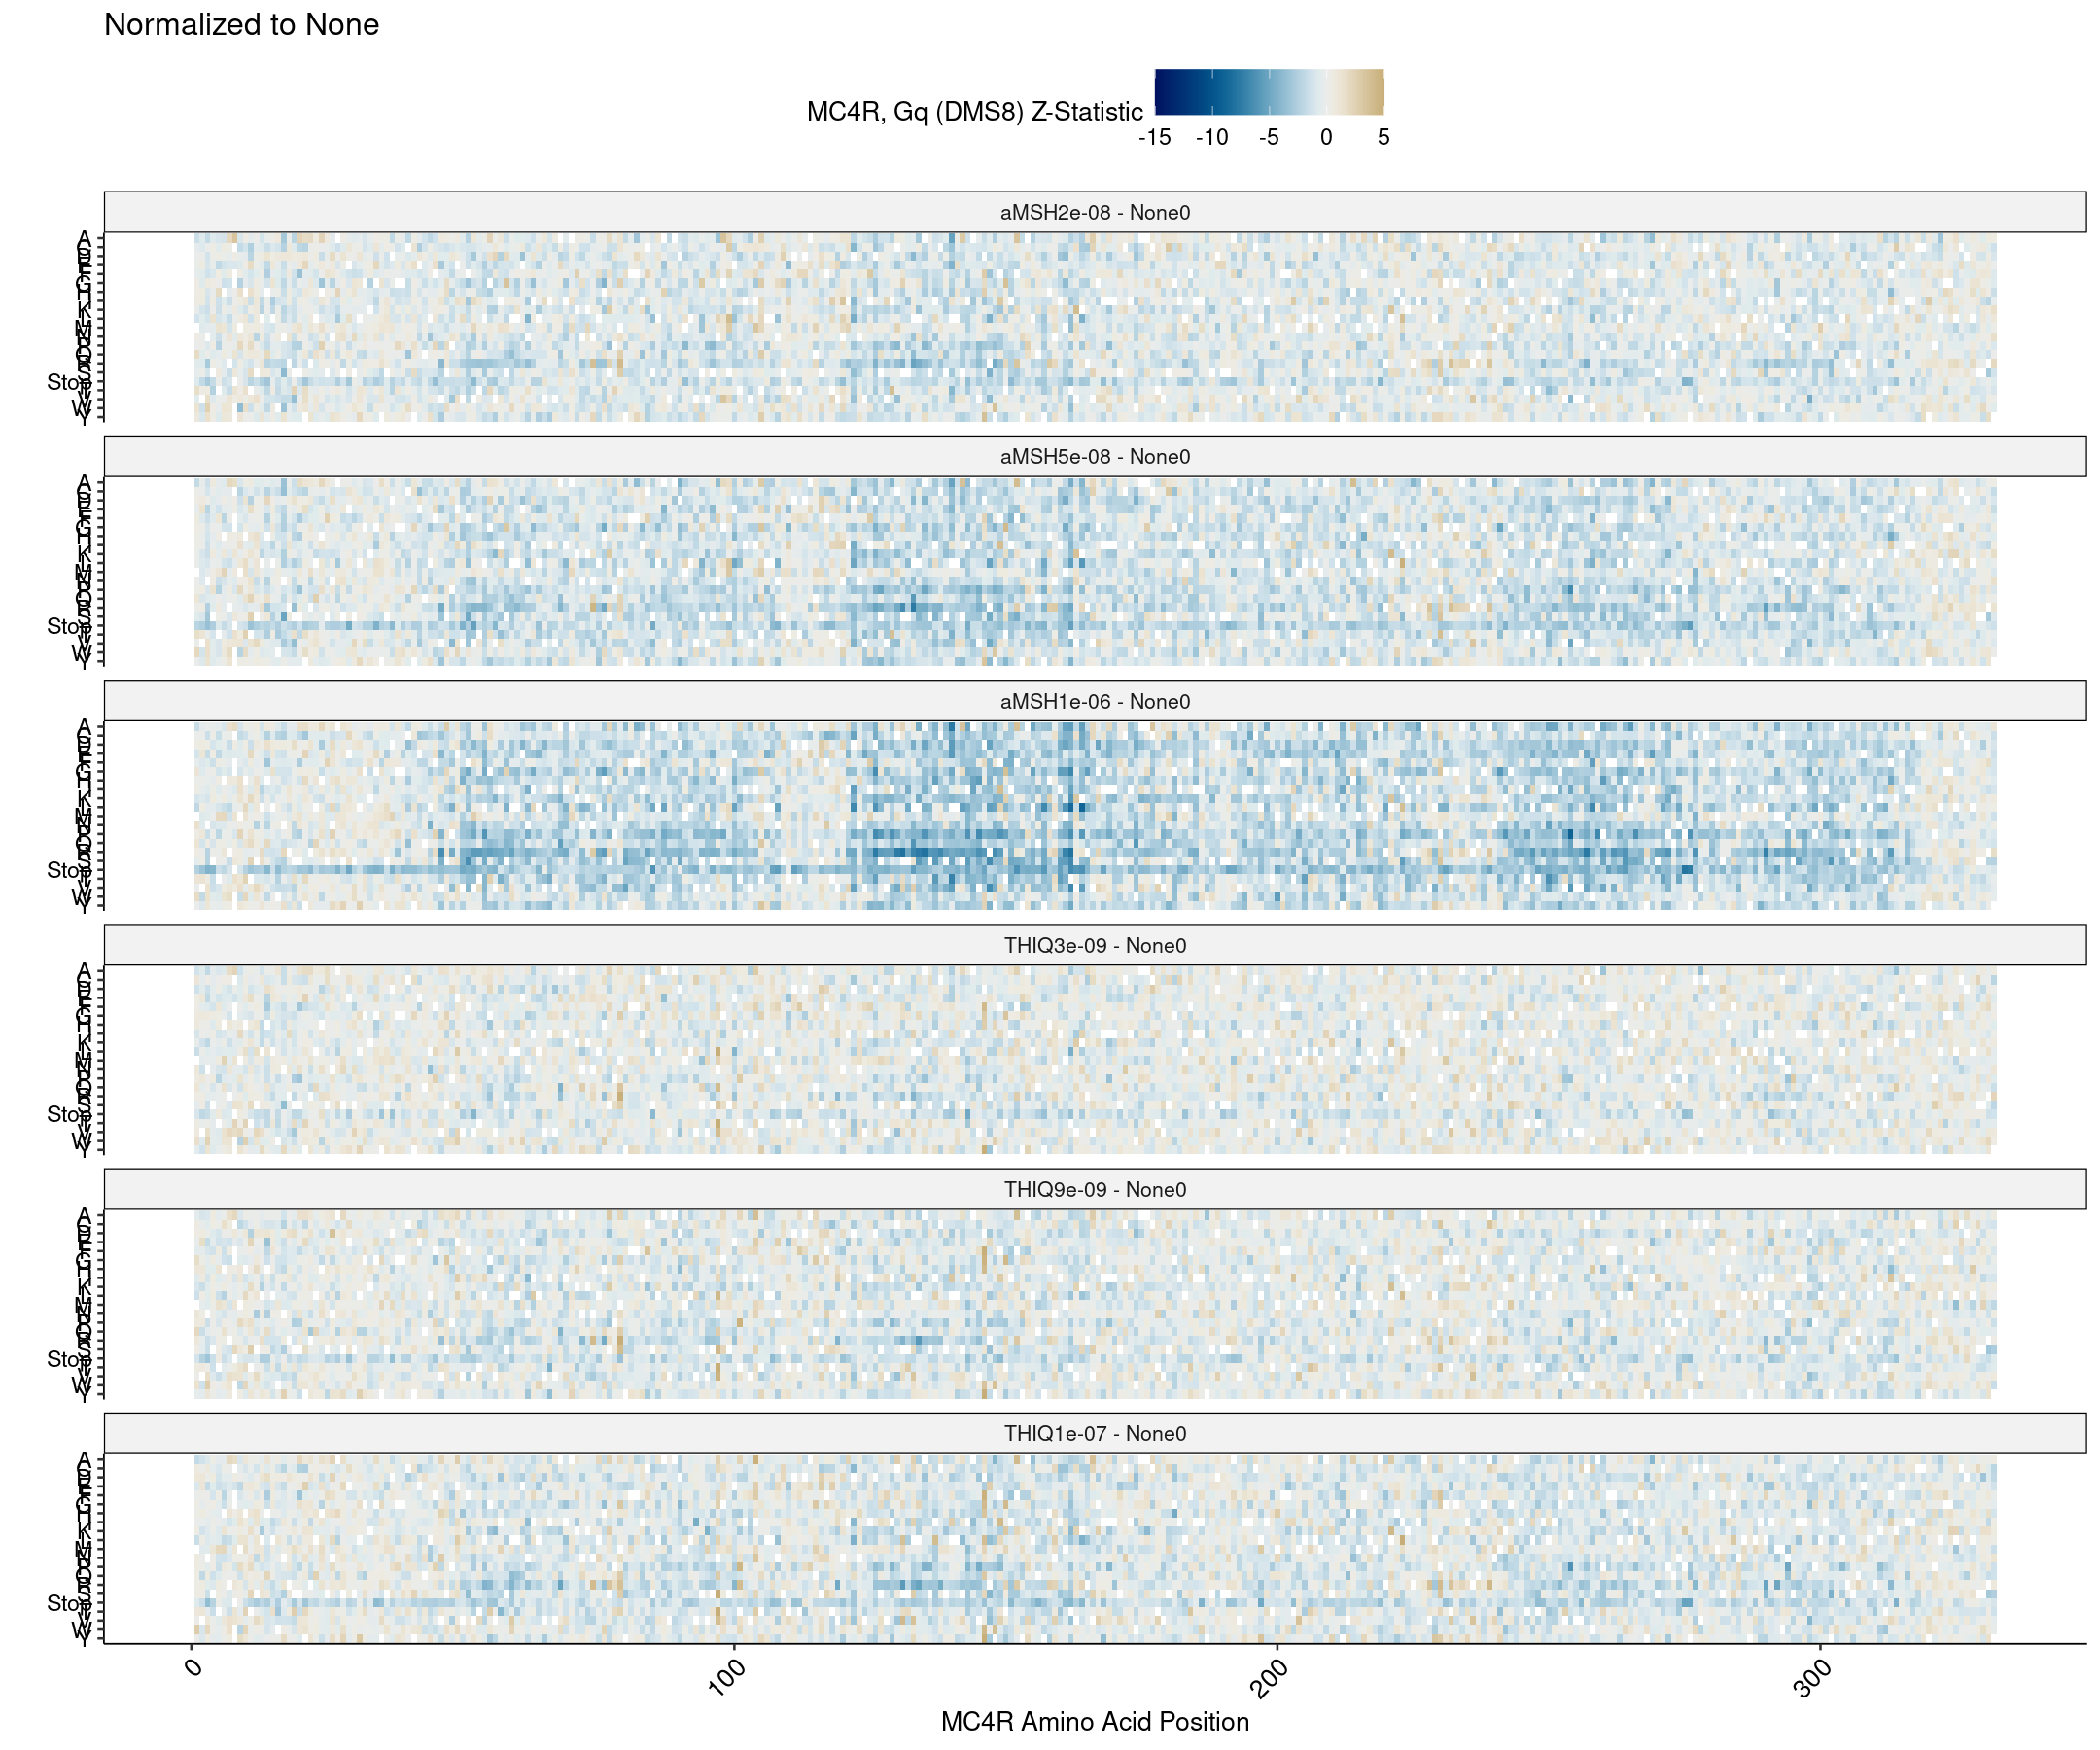

In [8]:
options(repr.plot.width = 18, repr.plot.height = 15)

missing <- expand_grid("aa" = aa_uniq, "pos" = pos_uniq) %>%
    left_join(sumstats_all, by = c("aa", "pos")) %>%
    filter(is.na(estimate), !paste0(pos,aa) %in% paste0(wt_aa$pos, wt_aa$wt_aa)) %>%
    select(aa, pos) %>%
    mutate(aa = if_else(aa %in% c("*", "X"), "Stop", aa))

sumstats_all %>%
    filter(grepl("- None0", condition)) %>%
    mutate(aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*", "X"), "Stop", aa)) %>%
    rename("MC4R, Gq (DMS8) Log2FoldChange" = "estimate") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill = `MC4R, Gq (DMS8) Log2FoldChange`)) +
            scale_fill_scico_mid(limits = c(-3,5), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("MC4R Amino Acid Position") +
            facet_wrap(~condition, ncol = 1) +
            ggtitle("Normalized to None")

sumstats_all %>%
    filter(grepl("- None0", condition)) %>%
    mutate(aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*", "X"), "Stop", aa)) %>%
    rename("MC4R, Gq (DMS8) Z-Statistic" = "statistic") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill =`MC4R, Gq (DMS8) Z-Statistic`)) +
            scale_fill_scico_mid( limits = c(-15,5), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("MC4R Amino Acid Position") +
            facet_wrap(~condition, ncol = 1) +
            ggtitle("Normalized to None")

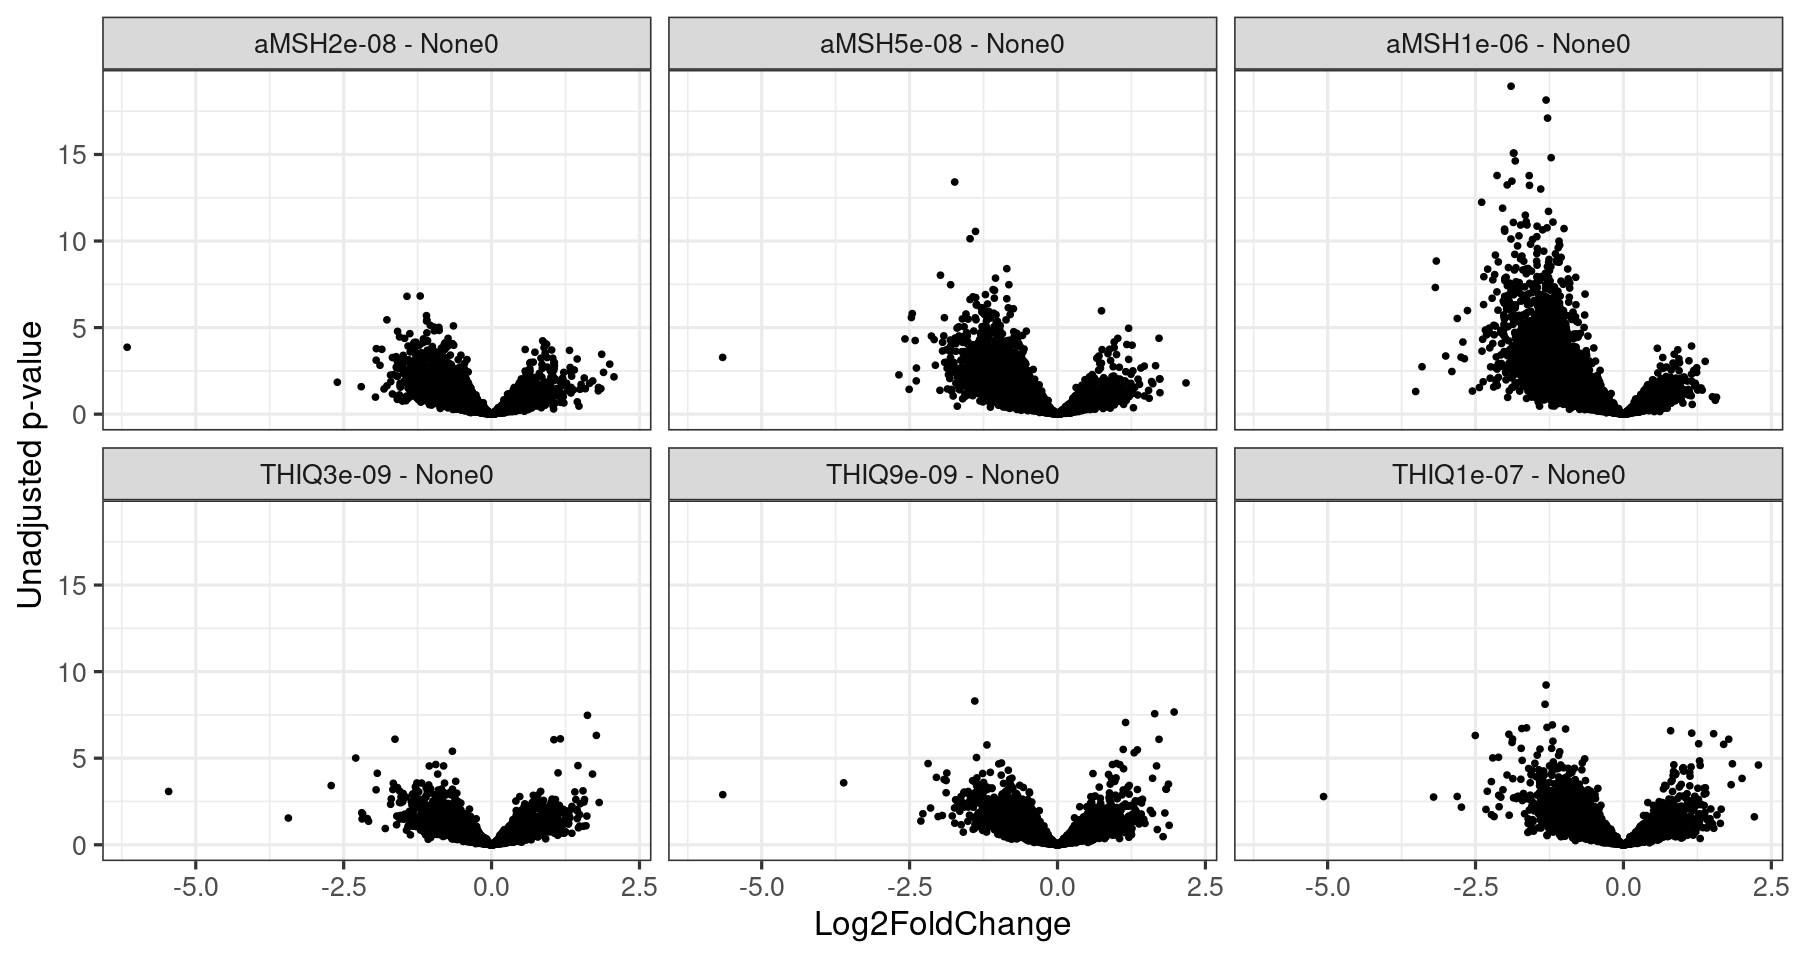

In [48]:
options(repr.plot.width = 15, repr.plot.height = 8)

sumstats_all %>%
    filter(grepl("- None0", condition)) %>%
    mutate(aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*", "X"), "Stop", aa)) %>%
    ggplot() +
        geom_point(aes(x = estimate, y = -log10(p.value))) +
        theme_bw(base_size = 20) +
        facet_wrap(~condition) +
        xlab("Log2FoldChange") + ylab("Unadjusted p-value")

### ClinVar <a name="part4"></a>

For MC4R, we know the association between ClinVar pathogenicity status and the observed summary statistics are quite strong for the Gs (DMS5) dataset. Since we have it on hand, we can extract just those variants which are annotated in ClinVar under various categories, and plot them across all conditions. We could do this for any variant subset, and so show a few selections below:

In [16]:
sumstats <- read_tsv("../sumstats/MC4R/MC4R-DMS8-Gq-unnormalized.tsv") %>%
    mutate(p.adj = p.adjust(p.value, method  = "fdr"))

wt_aa <- read_tsv("../data/mc4r/mc4r-wt-prot.tsv") %>%
    select(WT_AA_Short, Pos) %>%
    rename("pos" = "Pos", "wt_aa" = "WT_AA_Short")

aa_uniq <- unique(sumstats$aa)
pos_uniq <- 1:332

clinvar <- read_tsv("../data/annotations/clinvar_result_MC4R.txt") %>% select(-`Gene(s)`) %>% unique()
clinvar$significance <- gsub("\\(.*","",clinvar$`Clinical significance (Last reviewed)`)

Rows: 46431 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): condition, aa, version, group
dbl (7): pos, chunk, estimate, std.error, statistic, p.value, dispersion
lgl (1): clone

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 332 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): WT_AA_Short, WT_AA
dbl (1): Pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
* `` -> ...16

Warning message:
“One or more parsing issues, see `problems()` for details”
Rows: 193 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (14): Name, Gene(s), Protein change, Condition(s), Clinica

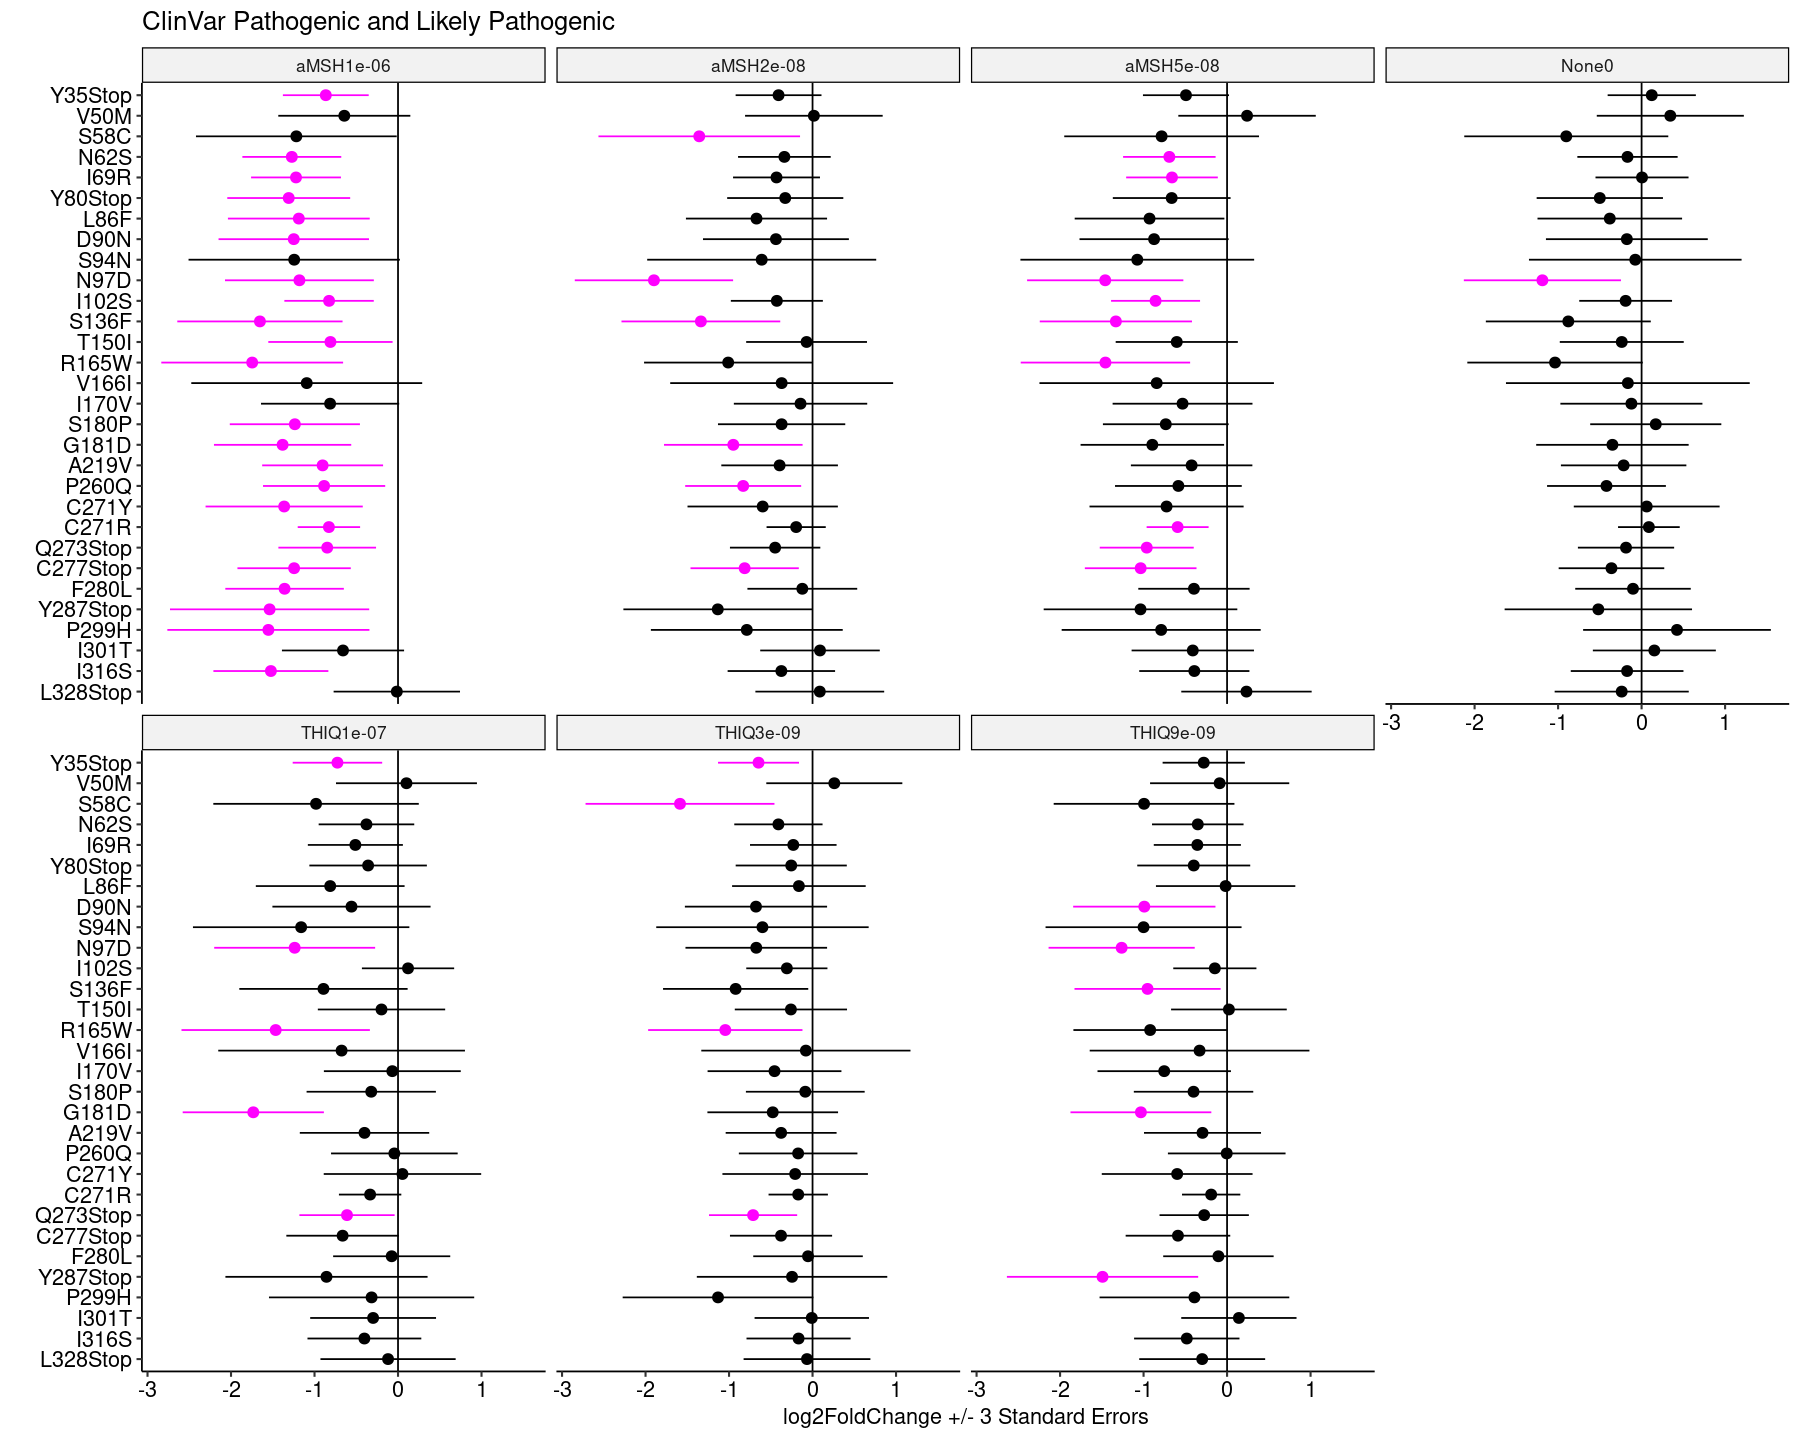

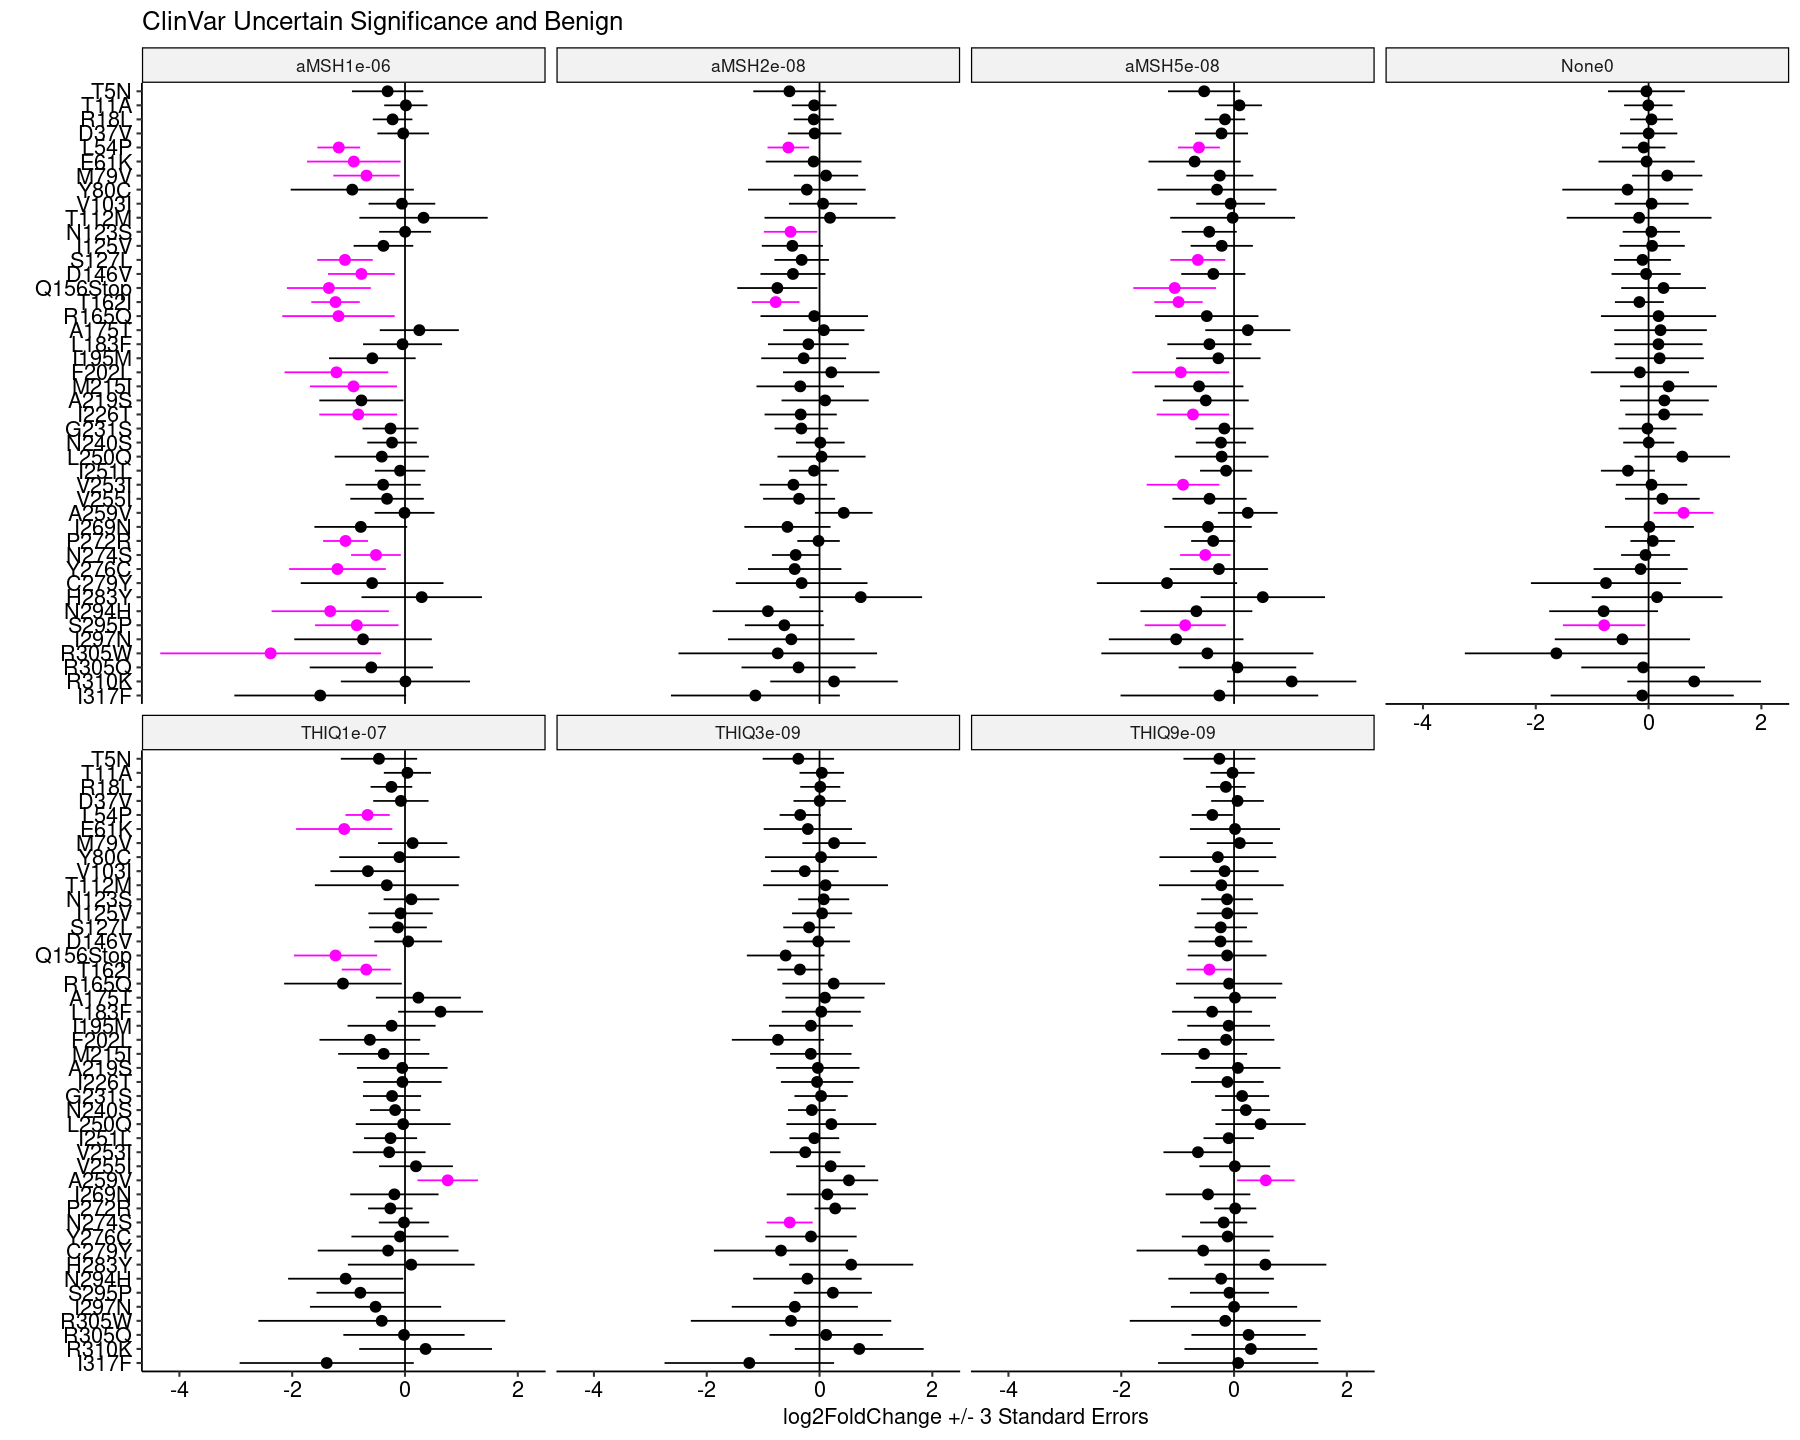

In [39]:
options(repr.plot.width = 15, repr.plot.height = 12)

clinvar_set <- clinvar %>% 
    filter(!is.na(`Protein change`), significance %in% c("Pathogenic", "Likely pathogenic")) %>%
    select(`Protein change`) %>% unlist()

sumstats %>%
    left_join(wt_aa, by = "pos") %>%
    filter(paste0(wt_aa, pos, aa) %in% clinvar_set) %>%
    mutate( aa = gsub("mut_aa", "", aa),
            aa = if_else(aa == "*", "Stop", aa)) %>%
    ggplot() +
        geom_pointrange(aes(x = reorder(paste0(wt_aa, pos, aa), -pos), y = estimate,
                            ymin = estimate - 3*std.error,
                            ymax = estimate + 3*std.error,
                            color = if_else(p.adj < 0.01, "magenta", "black"))) +
        theme_pubr(base_size = 13) +
        coord_flip() +
        geom_hline(yintercept = 0) +
        xlab("") + ylab("log2FoldChange +/- 3 Standard Errors") +
        facet_wrap(~condition, nrow = 2) +
        scale_color_identity() +
        ggtitle("ClinVar Pathogenic and Likely Pathogenic")

clinvar_set <- clinvar %>% 
    filter(!is.na(`Protein change`), !significance %in% c("Pathogenic", "Likely pathogenic")) %>%
    select(`Protein change`) %>% unlist()


sumstats %>%
    left_join(wt_aa, by = "pos") %>%
    filter(paste0(wt_aa, pos, aa) %in% clinvar_set) %>%
    mutate( aa = gsub("mut_aa", "", aa),
            aa = if_else(aa == "*", "Stop", aa)) %>%
    ggplot() +
        geom_pointrange(aes(x = reorder(paste0(wt_aa, pos, aa), -pos), y = estimate,
                            ymin = estimate - 3*std.error,
                            ymax = estimate + 3*std.error,
                            color = if_else(p.adj < 0.01, "magenta", "black"))) +
        theme_pubr(base_size = 13) +
        coord_flip() +
        geom_hline(yintercept = 0) +
        xlab("") + ylab("log2FoldChange +/- 3 Standard Errors") +
        facet_wrap(~condition, nrow = 2) +
        scale_color_identity() +
        ggtitle("ClinVar Uncertain Significance and Benign")

In [124]:
clinvar_dists <- sumstats %>%
    left_join(wt_aa, by = "pos") %>%
    mutate("Protein change" = paste0(wt_aa, pos, aa),
           "conc" = as.numeric(as.character(gsub("aMSH|THIQ|None", "", condition, perl = TRUE))),
           "drug" = str_sub(condition, 1, 4)) %>%
    left_join(clinvar, by = "Protein change") %>%
    mutate( aa = gsub("mut_aa", "", aa),
            aa = if_else(aa == "*", "Stop", aa),
           significance = if_else(is.na(significance), "Not in ClinVar", significance),
           significance = factor(significance, levels = c("Not in ClinVar", "Pathogenic", "Pathogenic/Likely pathogenic",
                                                          "Likely pathogenic", "Uncertain significance",
                                                          "Conflicting interpretations of pathogenicity",
                                                          "Likely benign", "Benign/Likely benign", "Benign")))

In [129]:
clinvar_plot <- clinvar_dists %>%
    ggplot(aes(x = fct_rev(significance),
               y = statistic,
               color = significance)) +
        geom_boxplot() +
        geom_quasirandom() +
        theme_pubr(base_size = 14) +
        coord_flip() +
        geom_hline(yintercept = 0) +
        theme(legend.pos = "none") +
        scale_color_igv() +
        xlab("") +
        facet_wrap(~drug + conc, ncol = 1)

ggsave("../dataviz/MC4R/MC4R-Gq-Unnormalized-ClinVar.pdf", clinvar_plot,
       width = 12, height = 25)

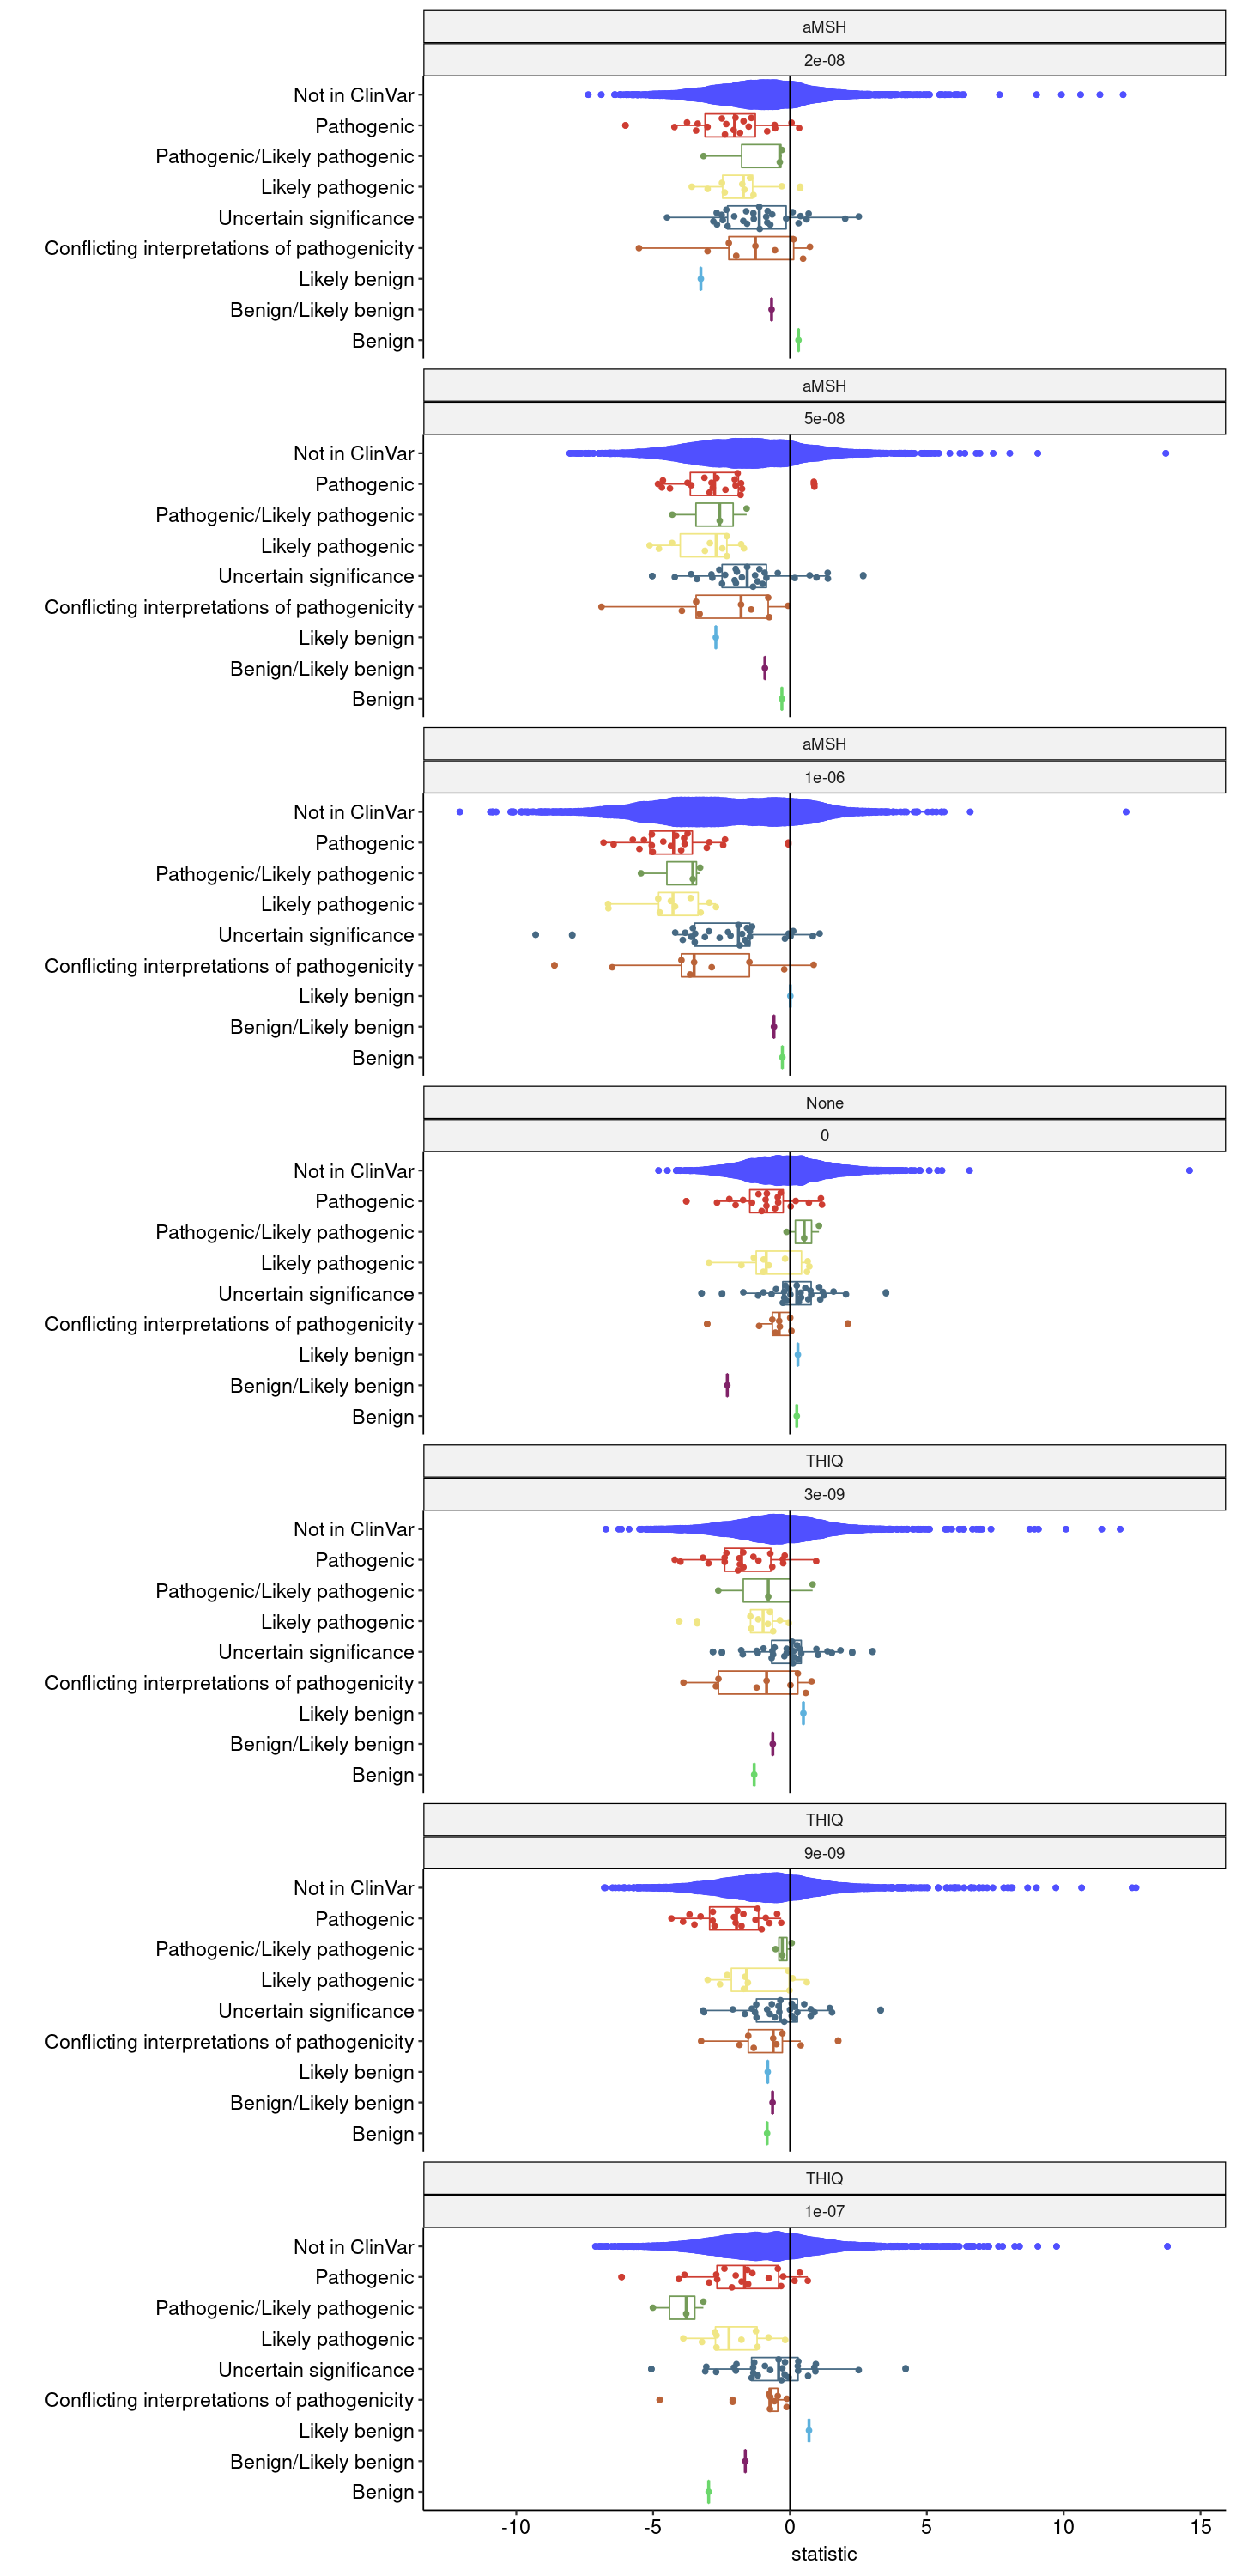

In [131]:
options(repr.plot.width = 12, repr.plot.height = 25)
clinvar_plot

### Unnormalized Summary Statistics <a name="part5"></a>

The summary statistics without any contrast or computed difference are located in the same directory as the normalized summary statistics [here](../sumstats/MC4R).

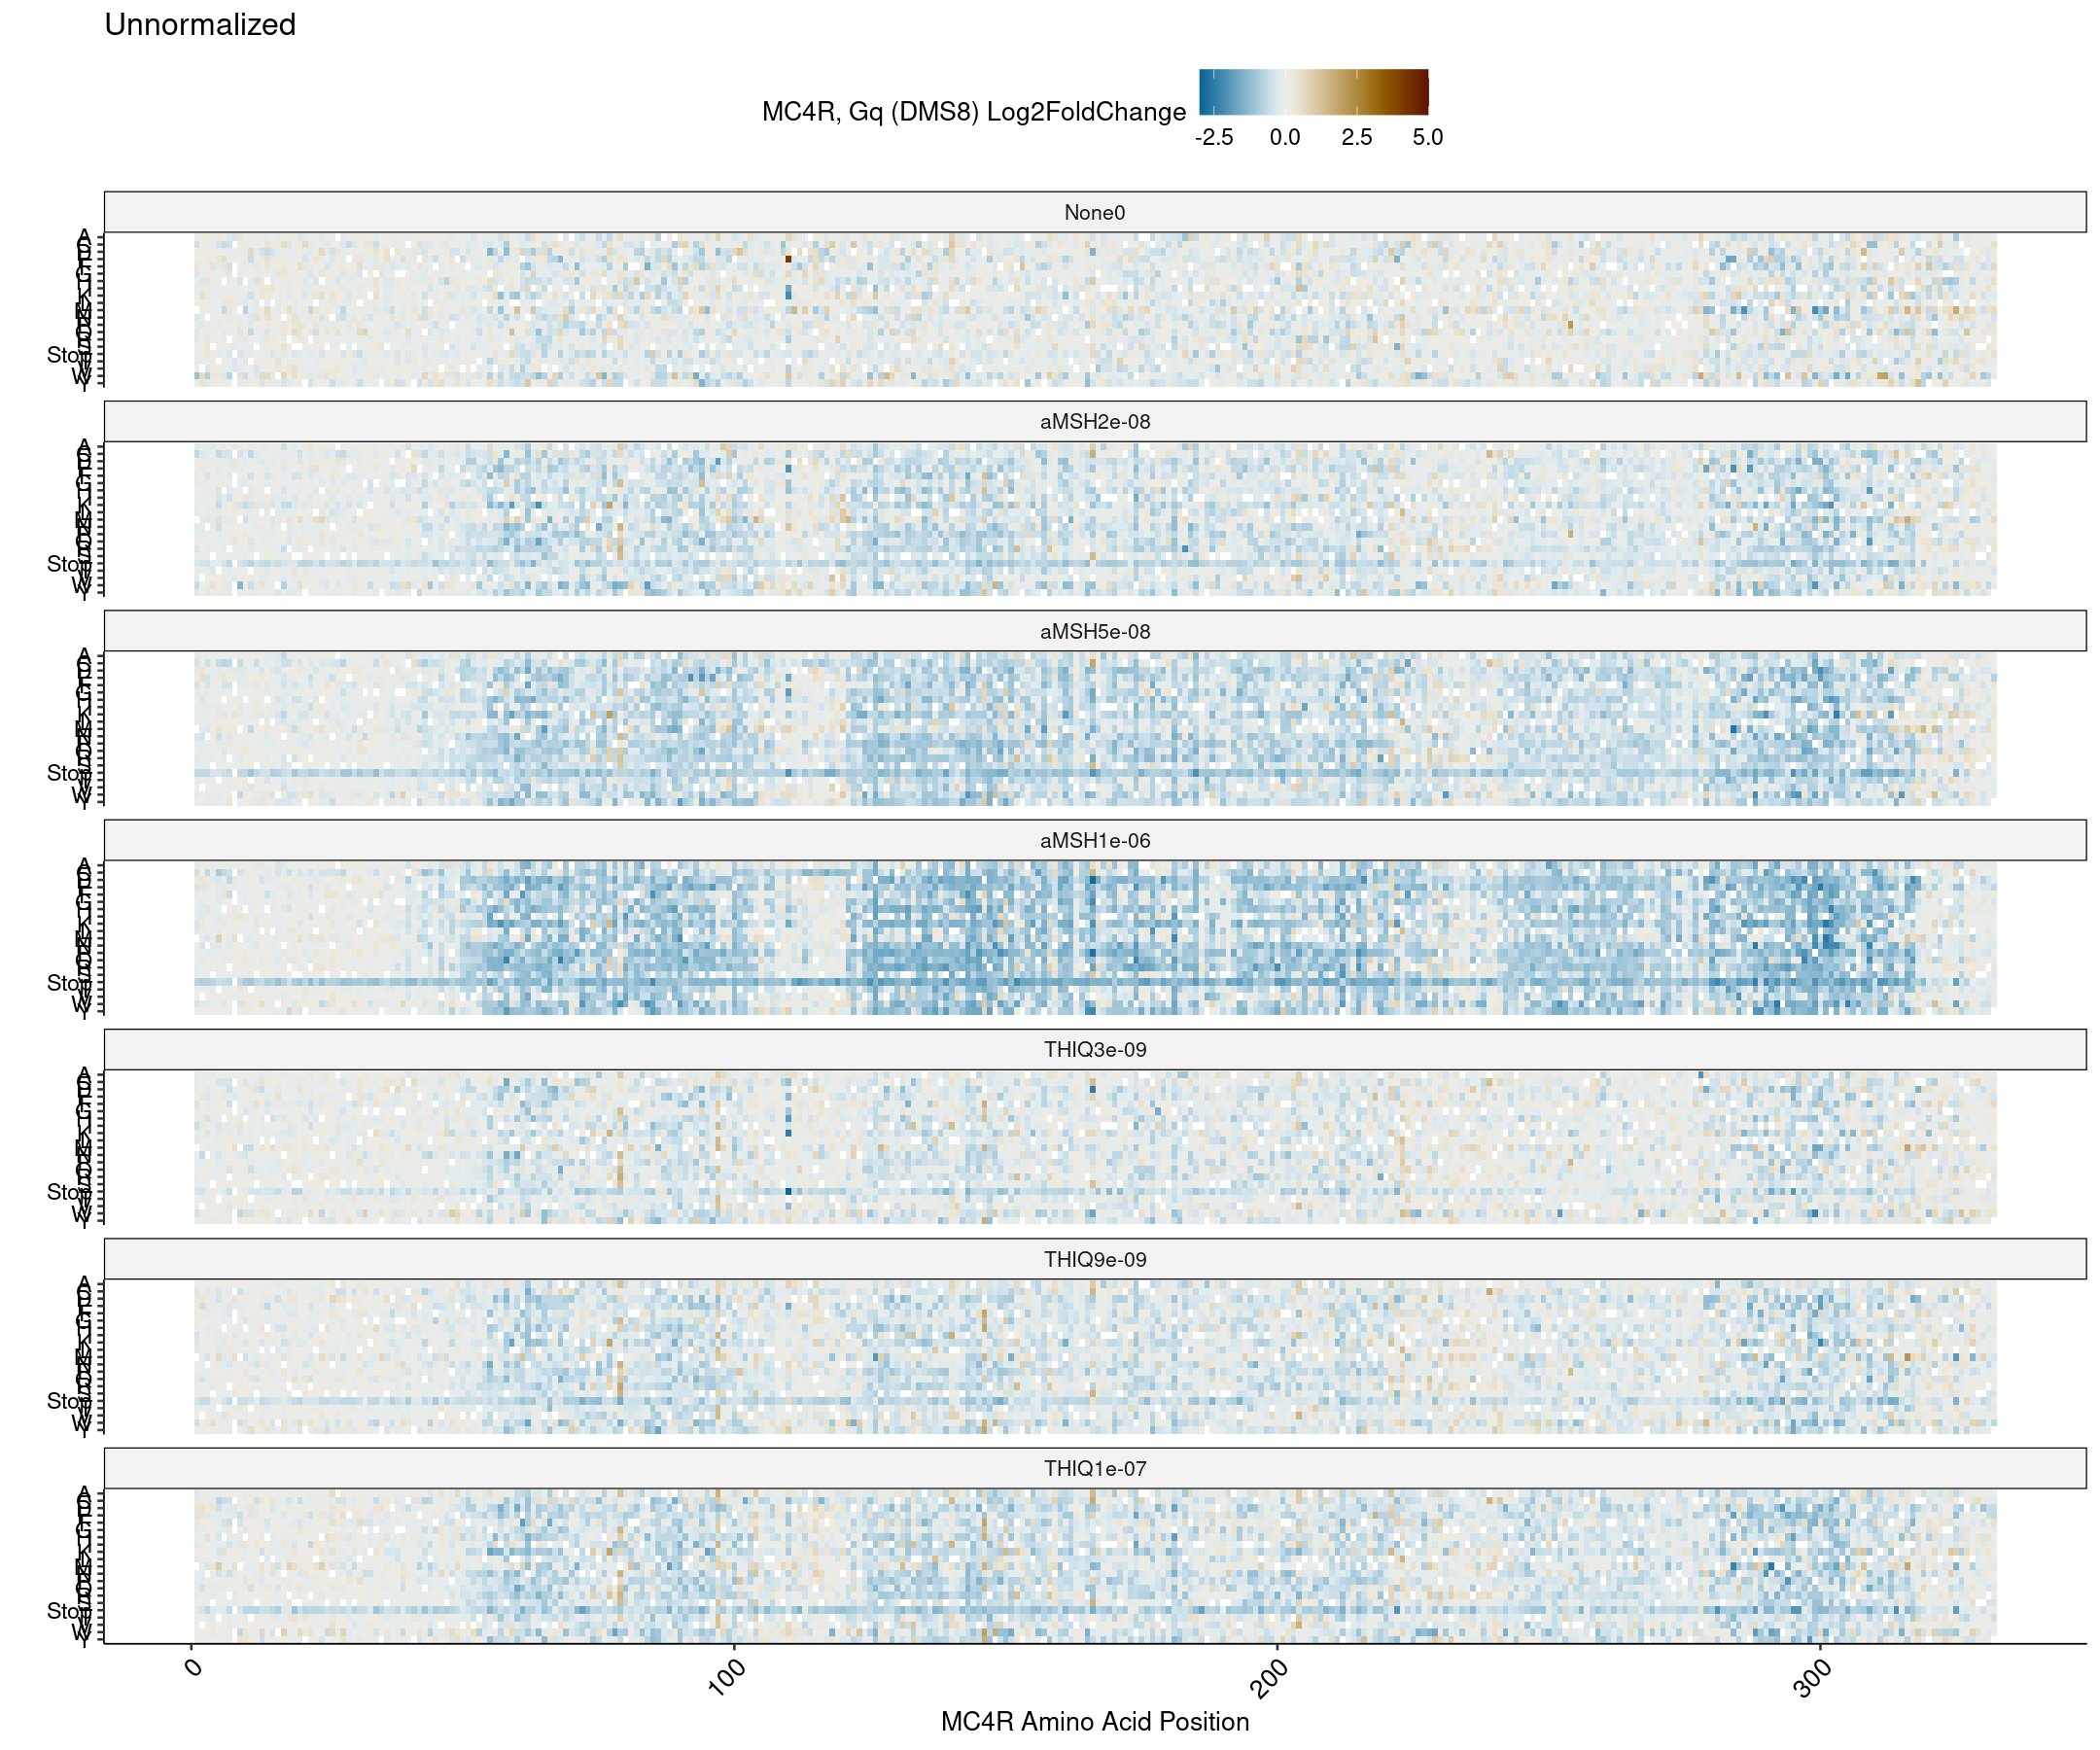

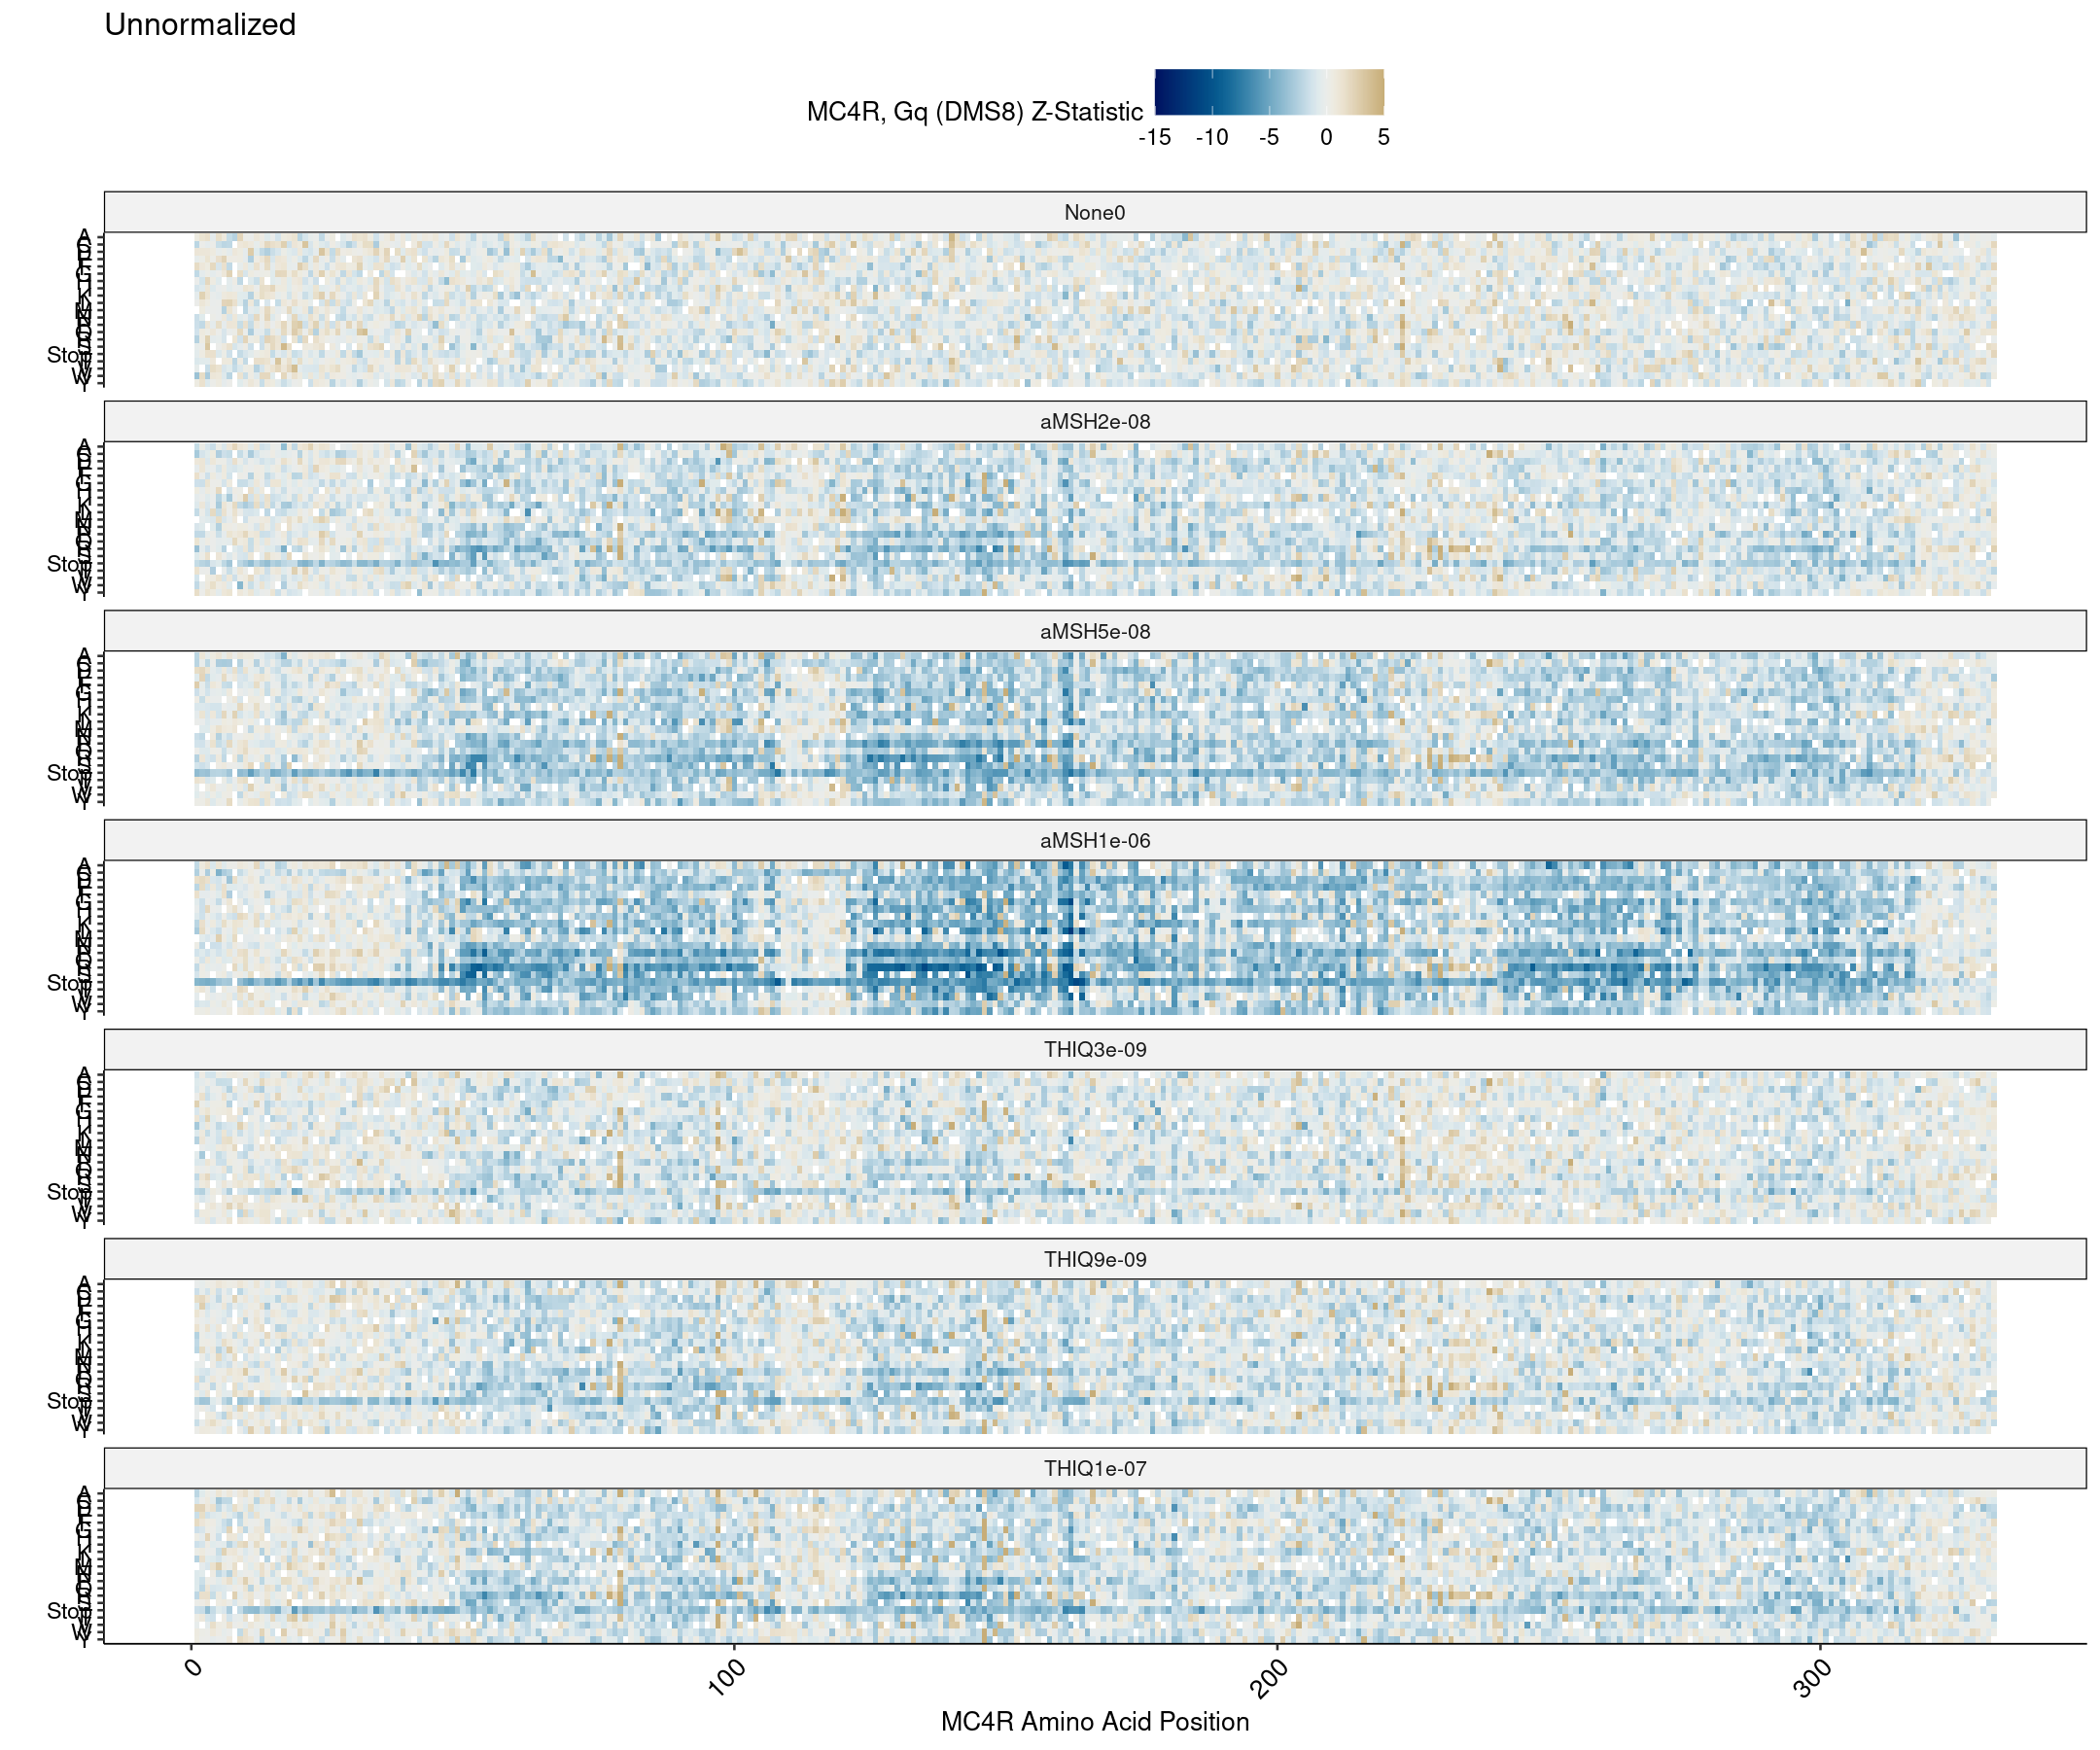

In [8]:
options(repr.plot.width = 18, repr.plot.height = 15)

sumstats_unnorm <- sumstats %>% 
    mutate(condition = factor(condition,
                              levels = c("None0",
                                         "aMSH2e-08",
                                         "aMSH5e-08",
                                         "aMSH1e-06",
                                         "THIQ3e-09",
                                         "THIQ9e-09",
                                         "THIQ1e-07")))

sumstats_unnorm %>%
    mutate(aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*", "X"), "Stop", aa)) %>%
    rename("MC4R, Gq (DMS8) Log2FoldChange" = "estimate") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill = `MC4R, Gq (DMS8) Log2FoldChange`)) +
            scale_fill_scico_mid(limits = c(-3,5), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("MC4R Amino Acid Position") +
            facet_wrap(~condition, ncol = 1) +
            ggtitle("Unnormalized")

sumstats_unnorm %>%
    mutate(aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*", "X"), "Stop", aa)) %>%
    rename("MC4R, Gq (DMS8) Z-Statistic" = "statistic") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill =`MC4R, Gq (DMS8) Z-Statistic`)) +
            scale_fill_scico_mid( limits = c(-15,5), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("MC4R Amino Acid Position") +
            facet_wrap(~condition, ncol = 1) +
            ggtitle("Unnormalized")

In [9]:
sumstats_unnorm %>% write_tsv("../sumstats/MC4R/MC4R-DMS8-Gq-unnormalized.tsv")

### Comparing aMSH to THIQ <a name="part6"></a>

We have three concentrations each for aMSH and THIQ. If we match these conditions together as "Low", "Medium", and "High" we can compute the pairwise difference in mutation effets between aMSH and THIQ at each level. This generates a new set of summary statistics, which are shown below. 

In [12]:
sumstats_drug_high <- compute_difference("aMSH1e-06", "THIQ1e-07", sumstats) %>%
    mutate(group = "High")
sumstats_drug_med <- compute_difference("aMSH5e-08", "THIQ9e-09", sumstats) %>%
    mutate(group = "Medium")
sumstats_drug_low <- compute_difference("aMSH2e-08", "THIQ3e-09", sumstats) %>%
    mutate(group = "Low")

sumstats_drug <- bind_rows(sumstats_drug_low, sumstats_drug_med, sumstats_drug_high) %>%
    mutate(statistic = estimate / std.error,
           p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                                 (1-pnorm(statistic, sd = 1))*2),
           p.adj = p.adjust(p.value, method = "BH"))

In [13]:
options(repr.plot.width = 18, repr.plot.height = 5)

generate_heatmaps <- function(s_stats, group){
    lfc_plot <- s_stats %>%
        mutate(aa = gsub("mut_aa", "", aa),
               aa = if_else(aa %in% c("*", "X"), "Stop", aa)) %>%
        rename("MC4R, Gs (DMS5) Log2FoldChange" = "estimate") %>%
        ggplot() +
                geom_tile(aes(x = pos, y = fct_rev(aa), fill = `MC4R, Gs (DMS5) Log2FoldChange`)) +
                scale_fill_scico_mid(limits = c(-3,5), palette = "vik", mid = 0, oob = squish) +
                theme_pubr(base_size = 16, x.text.angle = 45) +
                theme(legend.text=element_text(size=14),
                      legend.key.size = unit(1,"cm"),
                      axis.text.y = element_text(size = 14)) +
                ylab("") + xlab("MC4R Amino Acid Position") +
                facet_wrap(~condition, ncol = 1) +
                ggtitle(paste0("aMSH vs THIQ: ", group," Concentration"))
    
    z_plot <- s_stats %>%
        mutate(aa = gsub("mut_aa", "", aa),
               aa = if_else(aa %in% c("*", "X"), "Stop", aa)) %>%
        rename("MC4R, Gs (DMS5) Z-Statistic" = "statistic") %>%
        ggplot() +
                geom_tile(aes(x = pos, y = fct_rev(aa), fill =`MC4R, Gs (DMS5) Z-Statistic`)) +
                scale_fill_scico_mid( limits = c(-15,5), palette = "vik", mid = 0, oob = squish) +
                theme_pubr(base_size = 16, x.text.angle = 45) +
                theme(legend.text=element_text(size=14),
                      legend.key.size = unit(1,"cm"),
                      axis.text.y = element_text(size = 14)) +
                ylab("") + xlab("MC4R Amino Acid Position") +
                facet_wrap(~condition, ncol = 1)
    
    the_plot <- lfc_plot / z_plot
    
    return(the_plot)
}

high_plot <- generate_heatmaps(sumstats_drug %>% filter(group == "High"), "High")
med_plot <- generate_heatmaps(sumstats_drug %>% filter(group == "Medium"), "Medium")
low_plot <- generate_heatmaps(sumstats_drug %>% filter(group == "Low"), "Low")

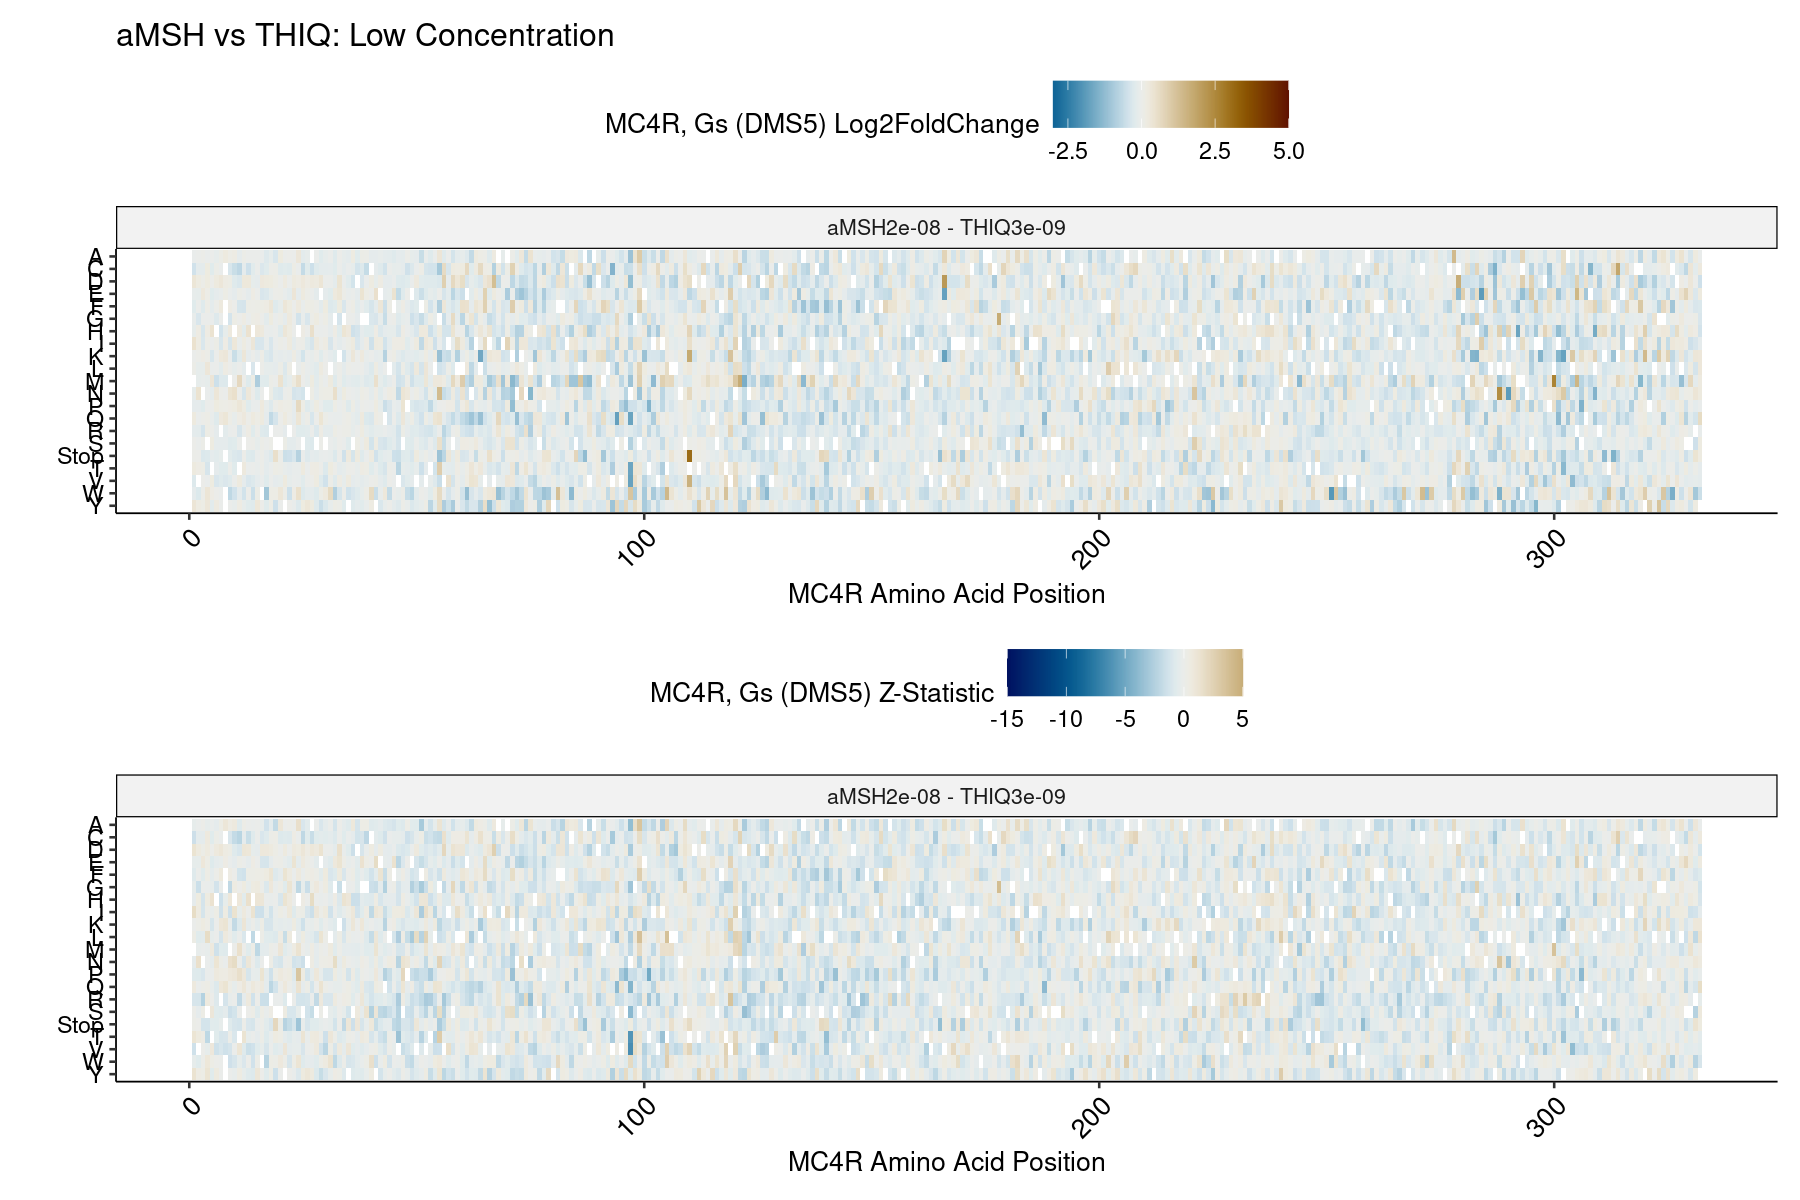

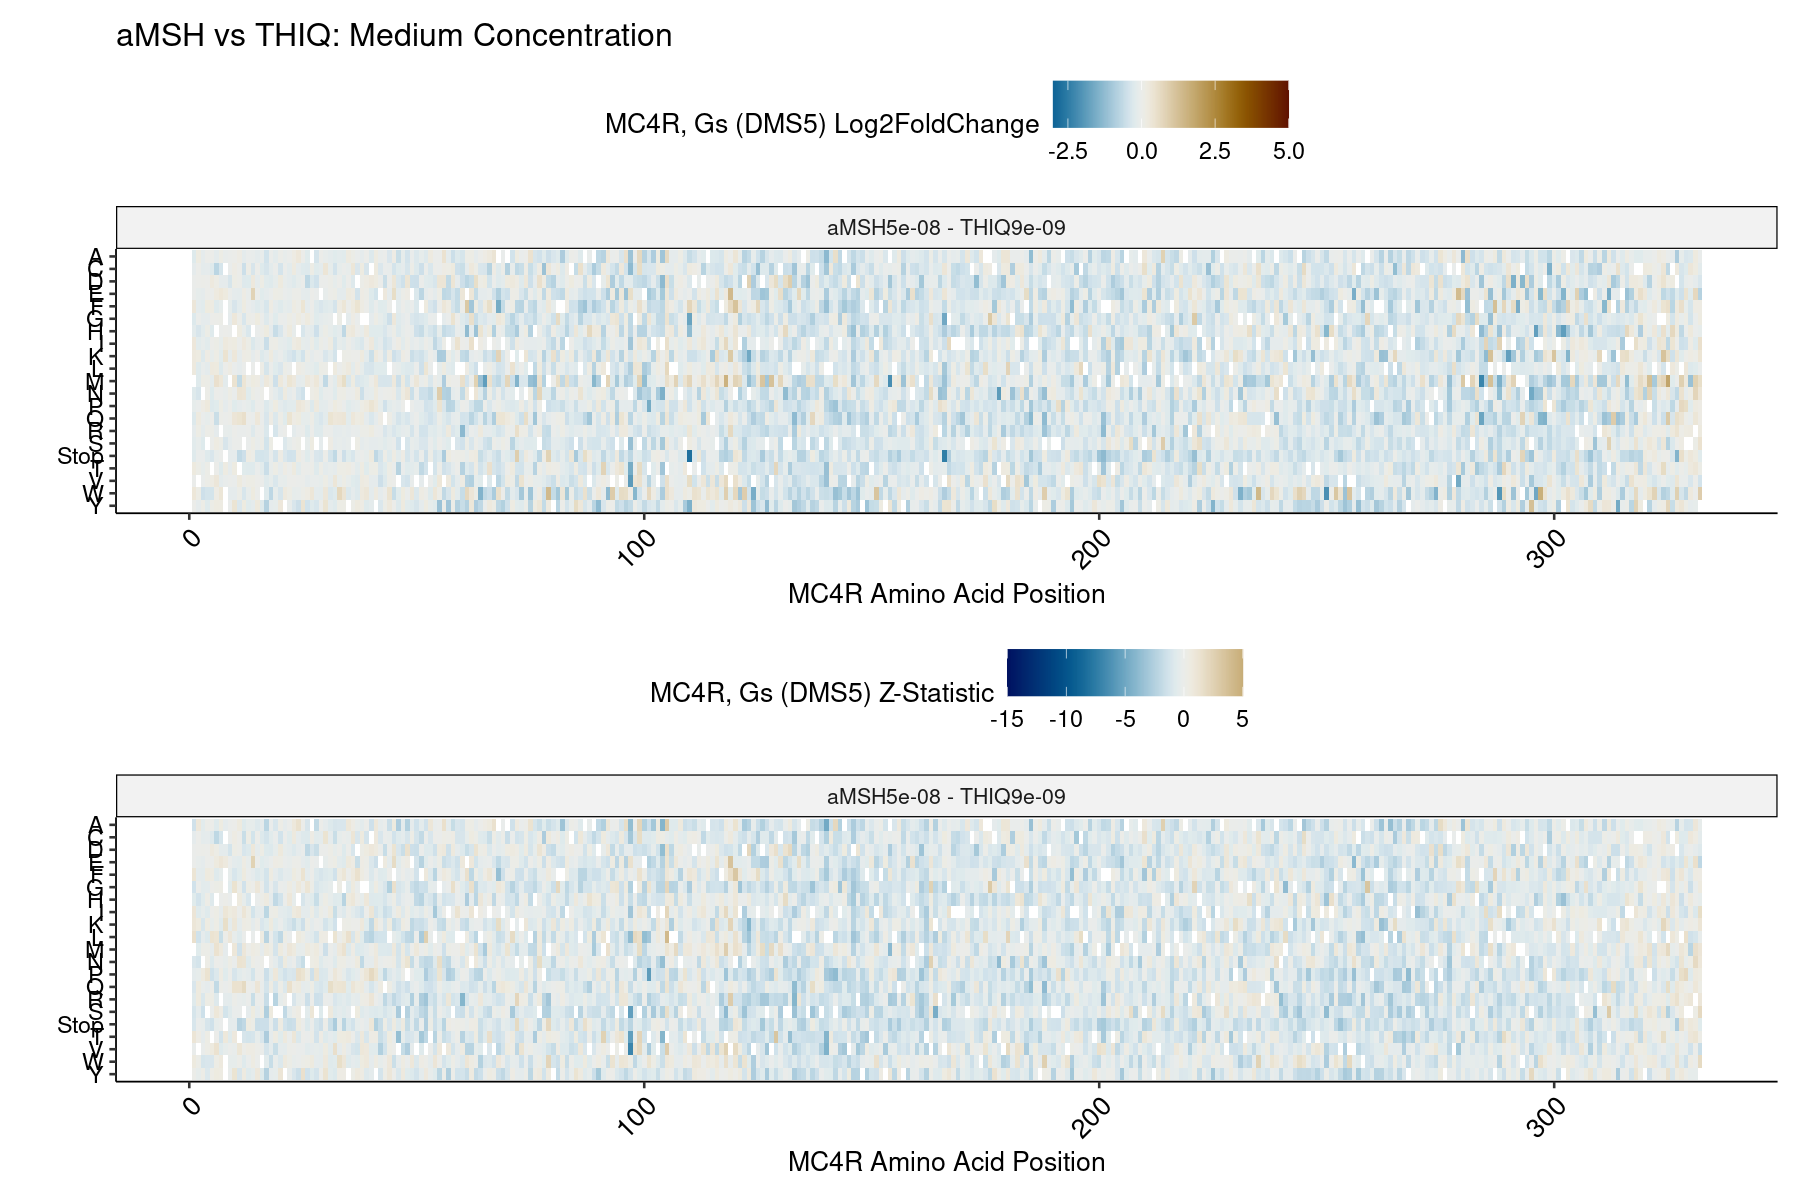

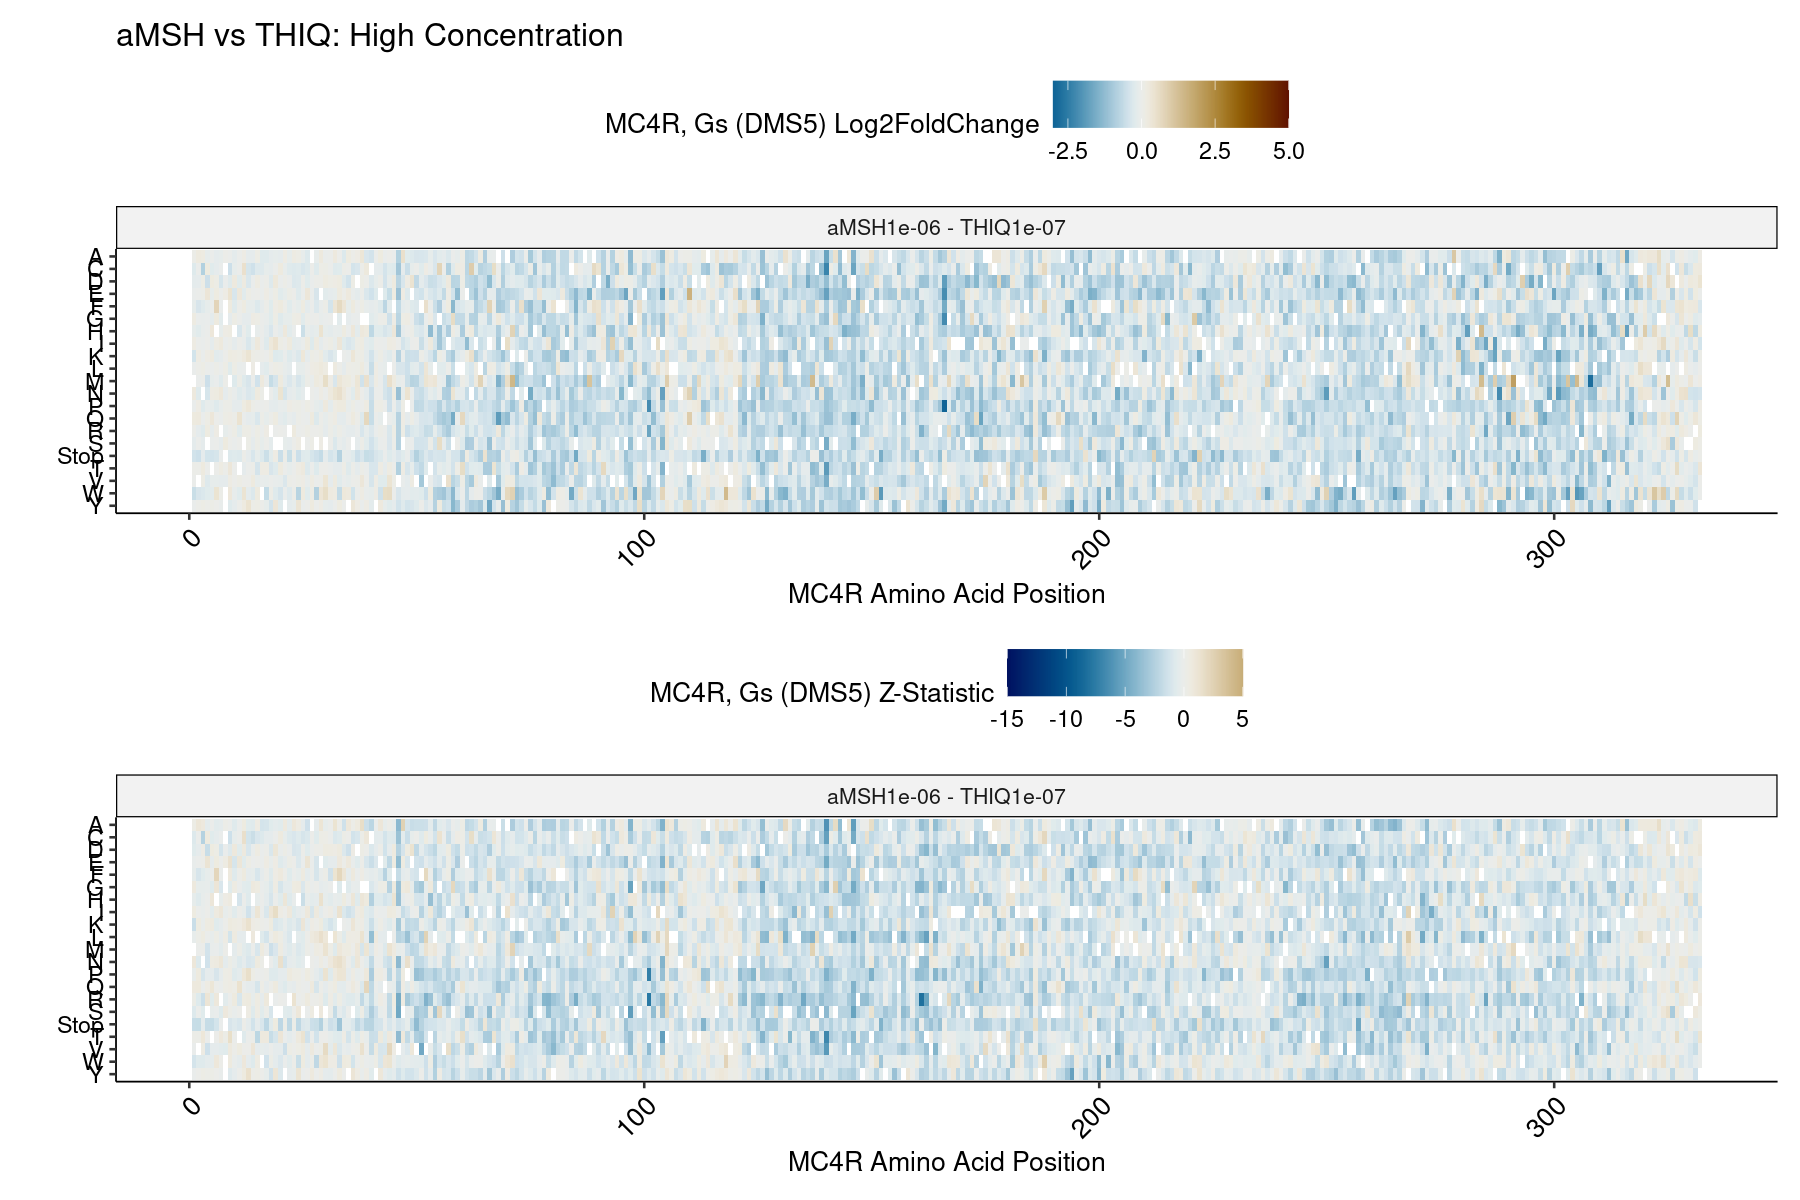

In [14]:
options(repr.plot.width = 15, repr.plot.height = 10)
low_plot
med_plot
high_plot

Most of these effects are negative, including a faint band of stops. This means that many variant effects are _more negative_ in aMSH compared to THIQ. This may reflect systematic differences, e.g. in the dosage of each compound. However, we can check which variants reverse this trend, namely those that are more negative in THIQ (instead of aMSH). Doing so, and imposing a FDR of 0.01, we find a resulting set of "THIQ-inhibiting" variants:

In [18]:
sumstats_drug %>%
    filter(p.adj < 0.01, estimate > 0) %>%
    select(pos, chunk, aa, estimate, std.error, p.adj, condition) %>%
    kable("markdown")



| pos|chunk |aa | estimate| std.error|     p.adj|condition             |
|---:|:-----|:--|--------:|---------:|---------:|:---------------------|
| 105|2     |L  | 0.697024| 0.1704212| 0.0097851|aMSH5e-08 - THIQ9e-09 |

In contrast to Gs/DMS5, we don't see too much here other than a single variant at position 105.

In [ ]:
sumstats_drug %>% write_tsv("../sumstats/MC4R/MC4R-DMS8-Gq-drugCompare.tsv")